# Batch Processing of Plots using the Selection for Data

NUE SELECTION

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


In [2]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

In [3]:
params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [4]:
# Set False if doing Run 1, True if doing Run 3

isRun3 = True

ending = "Sept19"

## NUE_NUE SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#full sample
if isRun3 == False:
    NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
elif isRun3 == True:
    NUE  = '/neutrinoselection_filt_run3b_overlay_intrinsic'+ls.APPEND

#actually fetch datasets
nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_nue]

nue_variables = ["run", "sub", "evt", 'swtrig_pre',            
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

#nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + nue_varMC, flatten=False)
nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + SYSTEMATICS + PPFX + nue_varMC, flatten=False)

['swtrig_pre', 'tksh_distance', 'evt', 'shr_tkfit_npoints', 'slnunhits', 'shr_tkfit_nhits_U', 'nproton', 'CosmicIPAll3D', 'topological_score', 'npion', 'shr_score', 'ccnc', 'tksh_angle', 'shrsubclusters2', 'reco_nu_vtx_sce_z', 'slnhits', 'elec_e', 'n_showers_contained', 'shr_energy_tot_cali', 'shr_px', 'shr_pz', 'reco_nu_vtx_sce_y', 'shr_distance', 'shr_tkfit_dedx_U', 'selected', 'flash_time', 'shr_phi', 'contained_fraction', 'run', 'shr_energy_cali', 'n_tracks', 'trk_energy', 'shr_tkfit_dedx_Y', 'shr_tkfit_nhits_V', 'hits_ratio', 'shrmoliereavg', 'nu_pdg', 'trk_energy_tot', 'reco_nu_vtx_sce_x', 'sub', 'proton_e', 'shr_tkfit_nhits_Y', 'trkshrhitdist2', 'shrsubclusters0', 'shr_py', 'shr_tkfit_dedx_V', 'n_showers', 'shrsubclusters1', 'n_tracks_contained', 'shr_theta', 'nslice', 'npi0', 'shr_energy', 'category', 'trk_score_v']


In [6]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_nue]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [7]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_nue]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [8]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)

if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    nue_intrinsic_pot = 2.37838E22 #matches Alex
elif isRun3 == True:
    beamon_pot = 5.014E20 #v5
    nue_intrinsic_pot = 2.5345e+22

nue_nue['pot_scale'] = beamon_pot/nue_intrinsic_pot

In [9]:
nue_nue['totweight_data'] = nue_nue['pot_scale']*nue_nue['weightSplineTimesTuneTimesPPFX']

In [10]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [11]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [11]:
#This assumes the electron to be the leading shower

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

KeyboardInterrupt: 

In [12]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_nue]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  17.851617097854614


In [13]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [14]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [15]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_nue]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_e"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])


In [16]:
"""
for i,df in enumerate(df_v):

    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
"""

In [15]:
# add back the cosmic category, for background only
#df_v = [nue_nue]
#for i,df in enumerate(df_v):
#    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    

In [16]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_nue]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [17]:
#Define signal catagories

#nue_nue["is_signal"] = nue_nue["category"] == 11

In [17]:
# Some quick clean up since some strange events get in there
nue_nue   = nue_nue.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [18]:
#df_v = [nue_nue]
#for i,df in enumerate(df_v):
#    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
#    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
#    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

Set up complete. Set up BDT for Selection.

In [18]:

reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'


In [19]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
if isRun3==False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3==True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')

In [20]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_nue]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(124396, 108)


In [21]:
test = np.nansum(nue_nue.query(BDT_LOOSE_CUTS)["weightSplineTimesTuneTimesPPFX"])
print('total signal events = '+ str(test))

total signal events = 10960.34


In [22]:
datasets_bdt = nue_nue

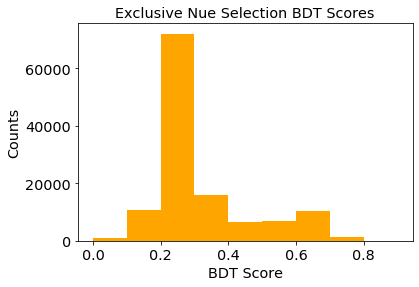

In [23]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [24]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1
      

In [25]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
NUE_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'

if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
NOT_SIGNAL_NUE_SEL_QUERY += 'and is_signal==False'

In [26]:
#New categories

for i,df in enumerate(df_v):
            
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)& (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [27]:
test = np.nansum(datasets_bdt.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 121.80220366092777


In [28]:
test = np.nansum(datasets_bdt.query(NUE_SEL_QUERY + 'and is_signal==True')['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 100.14679346454145


In [29]:
test = np.nansum(datasets_bdt.query(SIGNAL_NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 100.14679346454145


In [30]:
#truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
# 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
#truthsel_nue  += " and category == 11"
#truthsel_nue += ' and reco_e > 0.04 and reco_e < 5'

Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  124396
n_events/2 here =  24879.0

1.0
1
124396
{'nue_nue': 1}
 reco_e <= 5 & reco_e >= 0.05 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 nue_nue
current sample is:  nue_nue
[0.01319583 0.01439977 0.02220581 ... 0.02011352 0.01153746 0.01941844]
TEST
1
2
3
current_total  1542.0343500357455
1542.034350035745546847465448081493377685546875000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  1542.0343500357455
1542.034350035745546847465448081493377685546875000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  1542.0343500357455
1542.034350035745546847465448081493377685546875000000000000000000000000000000000
current_total_split  [0.25723284478730163, 66.55501542999323, 854.0501854860295, 621.1719162749356, 0.0]
---------------------------STILL TOGETHER HERE (PAST PLOTTING)--------------------------------

--------------

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


current_total_hist  [425.14690565 507.03433145 287.47764954 150.97989239  81.80502808
  44.65790206  21.64125425  13.04765762   6.89720378   3.34652521]
1542.034350035746

Returning
0
{'nue_nue': 1}
 reco_e <= 5 & reco_e >= 0.05 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 nue_nue
current sample is:  nue_nue
[]
Had to return early (colour sorting).


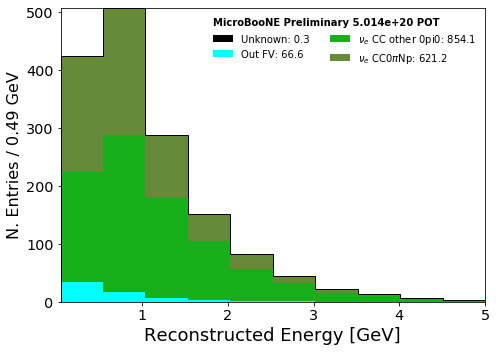

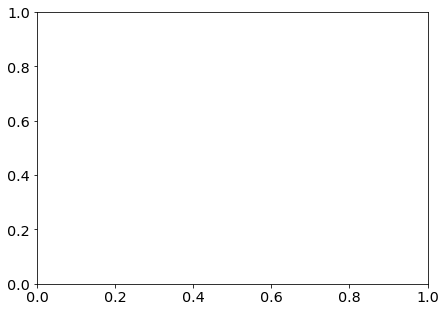

In [31]:
#WHAT WAS SELECTED

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/5))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]
    
    print(sample_set.shape[0])

    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 

    # NUE
    weights = { #full sample mc = 0.38
                #"nue_nue"  : nueratio  * SPLIT * scaling
                "nue_nue"  : 1
                #"nue_nue"   :  nue_nue['totweight_data']
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.05, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        #query= NUE_SEL_QUERY,
        query= "",
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        #genieweight = "weightSplineTimesTuneTimesPPFX",
        genieweight = "totweight_data",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

n_events here =  124396
n_events/2 here =  24879.0

1.0
1
124396
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575and is_signal==True& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_nue
[0.88510627 1.1240371  1.0383462  ... 1.0451999  0.7698529  0.64195037]
TEST
1
2
3
current_total  100.14679346454145
100.146793464541445928261964581906795501708984375000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  100.14679346454145
100.146793464541445928261964581906795501708984375000000000

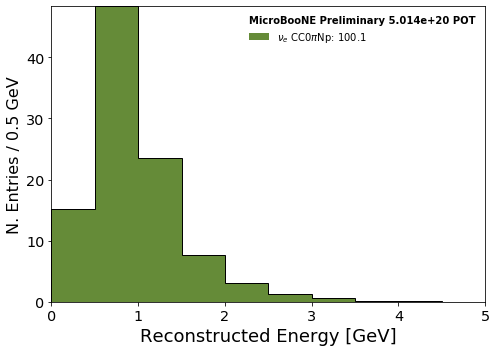

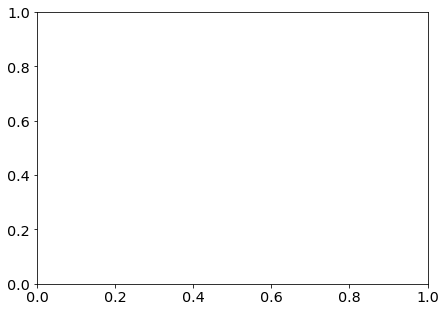

In [37]:
#THE TRUTH THAT WAS SELECTED

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/5))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]
    
    print(sample_set.shape[0])

    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 

    # NUE
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
                #"nue_nue"  : 1
                #"nue_nue"   :  nue_nue['totweight_data']
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= SIGNAL_NUE_SEL_QUERY,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",
        #genieweight = "totweight_data",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
No handles with labels found to put in legend.


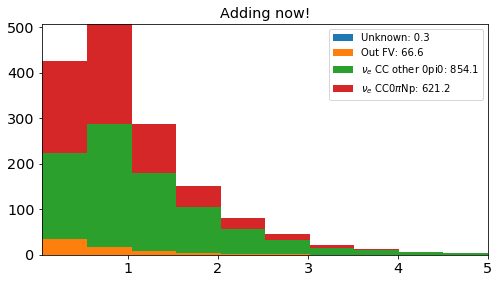

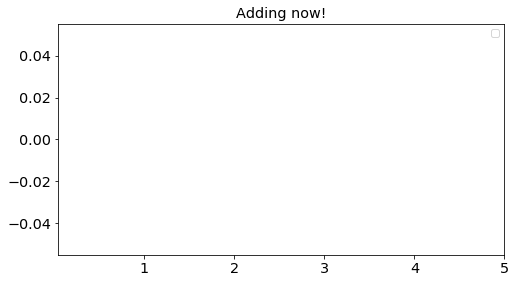

In [32]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0.04, 5.0])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [33]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

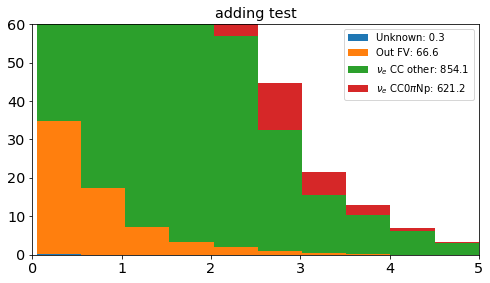

In [34]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}

labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0.0, 5.0])
nue_ax1.set_ylim([0, 60])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 35])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()


#print('%.75f' % sum(nue_stacked[0]))
#print(nue_stacked[0])

In [35]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0 #2

nue_wanted_list = nue_stacked[0]
#nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

#2 for not signal, 0 for signal
print(nue_wanted_list[0])
print(sum(nue_wanted_list[0]))

#print('%.75f' % nue_wanted_list[9])

[0.25723284 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
0.25723284478730163


In [36]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

is_selected = False


if isRun3 == False:
    if (is_selected == True):
        ######full trueE
        vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_'+ending+'.csv')
        weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
        ########leptonMom
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')
    elif (is_selected == False):
        ######full trueE
        vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_'+ending+'.csv')
        weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
        ########leptonMom
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')
if isRun3 == True:
    if (is_selected == True):
        ######full trueE
        vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_run3_usingSelection.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_run3_usingSelection.csv')
        ########leptonMom
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_run3_usingSelection.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_run3_usingSelection.csv')
    elif (is_selected == False):
        ######full trueE
        vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_run3_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_run3_usingSelection.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_run3_usingSelection.csv')
        ########leptonMom
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_run3_usingSelection.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_run3_usingSelection.csv')

### Stat Errors

In [43]:
#This is the stat errors on the selected signal nue

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= SIGNAL_NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  124396
n_events/2 here =  62198.0

1.0
1
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575and is_signal==True& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_nue

LOOK HERE FOR DETSYS
None
err nue: 
[2.74348182e-01 8.60224398e-01 3.94106446e-01 1.49893514e-01
 5.94877655e-02 2.38733796e-02 1.21323732e-02 3.13093503e-03
 1.17410063e-03 3.91366878e-04]
detsys nue: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [1.5261464e+01 4.8346680e+01 2.3597139e+01 7.6834569e+00 3.1137481e+00
 1.3187680e+00 5.9394175e-01 1.3983154e-01 7.1514003e-02

In [44]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

nue_nue_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_nue_stat_errs_selected = total_sels

total errs =  [0.2743481816546182, 0.86022439839779, 0.3941064463997155, 0.14989351437049753, 0.05948776549429667, 0.02387337957336906, 0.012132373225810504, 0.003130935026015614, 0.0011741006347558553, 0.0003913668782519518]

total selected =  [15.26146411895752, 48.3466796875, 23.597139358520508, 7.683456897735596, 3.113748073577881, 1.31876802444458, 0.5939417481422424, 0.13983154296875, 0.07151400297880173, 0.02024819143116474]


In [45]:
if isRun3 == False:
    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')


    """
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
if isRun3 == True:
    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')


    """
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

In [46]:
#This is the stat errors on the selected NOT signal nue

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NOT_SIGNAL_NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  124396
n_events/2 here =  62198.0

1.0
1
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575and is_signal==False& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_nue

LOOK HERE FOR DETSYS
None
err nue: 
[0.04031079 0.17259279 0.11975826 0.05361726 0.02152518 0.01134964
 0.00391367 0.00156547 0.         0.        ]
detsys nue: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [1.993578   9.3159685  5.9793496  2.4919372  1.0510519  0.52745986
 0.20868504 0.08737902 0.         0.        ]
Returning
{'nue_nue': 0.01978299467350562}
swtrig_pre=

In [47]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

nue_nue_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_nue_stat_errs_selected = total_sels

total errs =  [0.040310788459951036, 0.17259279330911073, 0.11975826474509724, 0.053617262320517396, 0.021525178303857348, 0.0113496394693066, 0.003913668782519517, 0.001565467513007807, 0.0, 0.0]

total selected =  [1.9935779571533203, 9.31596851348877, 5.979349613189697, 2.4919371604919434, 1.0510518550872803, 0.5274598598480225, 0.208685040473938, 0.08737901598215103, 0.0, 0.0]


In [48]:
if isRun3 == False:
    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')


    """
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
if isRun3 == True:
    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_run3_"+ending+".csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')


    """
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

### Sys Errors

In [49]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124396
n_events/2 here =  62198.0

1.0
1
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   590  \
0     1291   408   220   316   614  1208   713   788   682   385  ...  1035   
1     1228   256   748   403   693  1026  1895   837   626   513  ...   884   
2     1016  1037  1033  1006  1076  1044  1046  1055  1057  1006  ...  1033   
3      335   263   457  1108   624   821   663   473   793   922  ...  157

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[1.72550411e+01 5.76626434e+01 2.95764847e+01 1.01753922e+01
 4.16480255e+00 1.84622955e+00 8.02627563e-01 2.27210999e-01
 7.15103149e-02 2.02484131e-02]


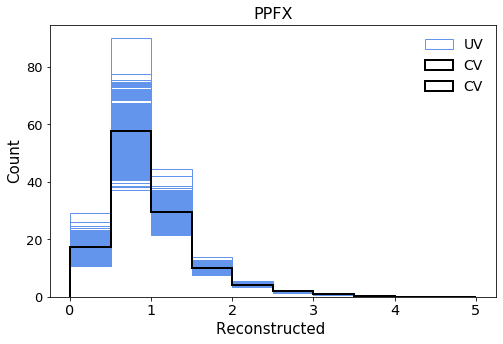

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


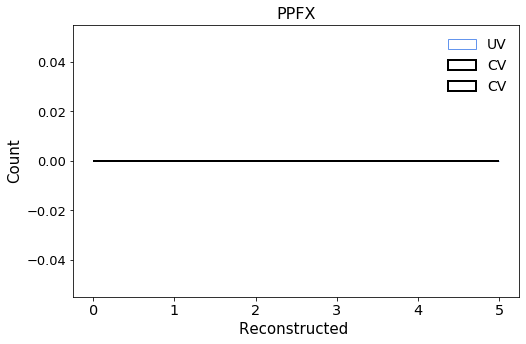

In [50]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [51]:
#will need to edit this if batching

nue_nue_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)
if isRun3 == False:
    nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')

In [52]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_nue_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
print(total_ppfx_df_splines)

entry
12        0.017510
23        0.022237
66        0.020542
76        0.016724
176       0.022730
            ...   
124247    0.015230
124278    0.012700
124350    0.019959
124369    0.011925
124379    0.008940
Name: weightSplineTimesTuneTimesPPFX, Length: 5630, dtype: float32


In [53]:
if isRun3 == False: 
    np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_nue_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True: 
    np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               final_ns_nue_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               final_ncvs_nue_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv')
    total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv')
    total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv')
    """
    """
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               final_ns_nue_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               final_ncvs_nue_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    """

In [54]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124396
n_events/2 here =  62198.0

1.0
1
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   590  \
0     1431  1044   819  1334  1086  1501  1160  1198  1365  1369  ...  1447   
1     1393  1073   871  1317  1108  1452  1171  1208  1343  1342  ...  1407   
2      536   739   333  1297  1010  1511   905  1470  1113  1373  ...   904   
3      757   975   441   989   567   989   893  1201   967  1234  ...   87

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[1.72550411e+01 5.76626434e+01 2.95764847e+01 1.01753922e+01
 4.16480255e+00 1.84622955e+00 8.02627563e-01 2.27210999e-01
 7.15103149e-02 2.02484131e-02]


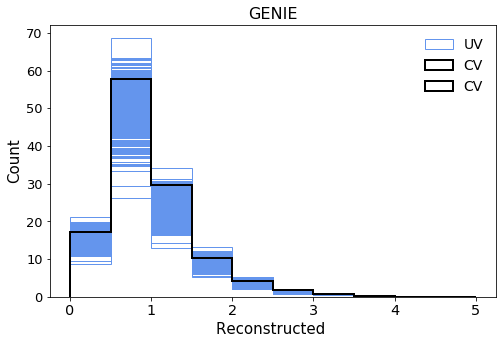

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


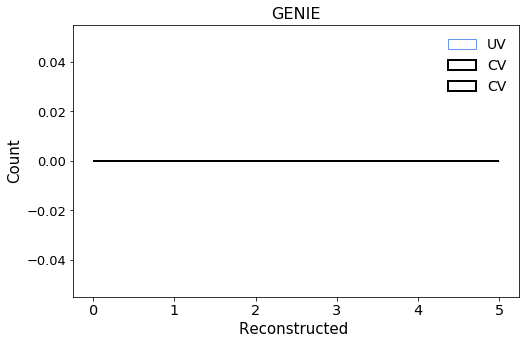

In [55]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('GENIE', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    plt.show()

In [56]:
#will need to edit this if batching

nue_nue_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')    

In [57]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_genie.append(sum(masterlist[a]))

final_ncvs_nue_nue_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [58]:
if isRun3 == False:
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """

    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """

    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv')
    """
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               final_ns_nue_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               final_ncvs_nue_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    """

In [59]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
#this time = nevents
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124396
n_events/2 here =  62198.0
weightsReint
1.0
1
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   990  \
0     1006   980  1085   992  1041   981   896   992   970  1029  ...   926   
1      936   826  1092  1010   895   970   974   955  1089   952  ...   924   
2      864   618  1415  1012   822   902   789   885  1179   933  ...   731   
3      948   852  1097  1007   921   971   955   961  1069   9

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[1.72550411e+01 5.76626434e+01 2.95764847e+01 1.01753922e+01
 4.16480255e+00 1.84622955e+00 8.02627563e-01 2.27210999e-01
 7.15103149e-02 2.02484131e-02]


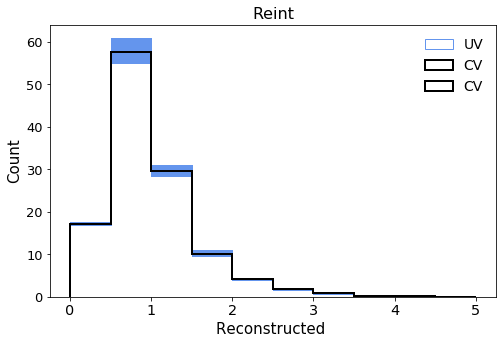

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


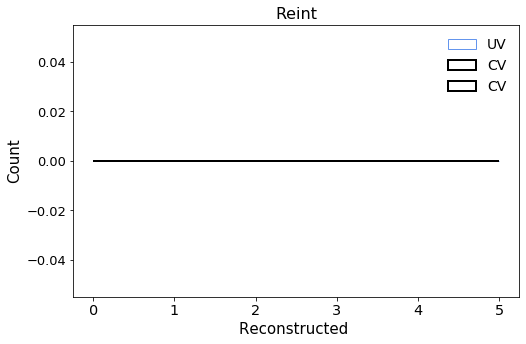

In [60]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [61]:
#will need to edit this if batching

nue_nue_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')    

In [62]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_reint.append(sum(masterlist[a]))

final_ncvs_nue_nue_reint = sum(n_cv_tots)
print(final_ncvs_nue_nue_reint)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
print(total_reint_df_splines)

[1.72550411e+01 5.76626472e+01 2.95764885e+01 1.01753941e+01
 4.16479969e+00 1.84622788e+00 8.02626789e-01 2.27210552e-01
 7.15140030e-02 2.02481914e-02]
       0     1     2     3     4     5     6     7     8     9    ...   990  \
0     1006   980  1085   992  1041   981   896   992   970  1029  ...   926   
1      936   826  1092  1010   895   970   974   955  1089   952  ...   924   
2      864   618  1415  1012   822   902   789   885  1179   933  ...   731   
3      948   852  1097  1007   921   971   955   961  1069   966  ...   920   
4      986   959  1027  1001   980   991   984   989  1016   992  ...   976   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
5625  1071  1234   707   998  1056  1074  1220  1074   913  1011  ...  1232   
5626   968   910  1048  1004   948   984   982   977  1042   977  ...   958   
5627   981   943  1035  1002   971   989   982   985  1024   988  ...   969   
5628   981   942  1039  1002   972   988   978   984  10

In [63]:
if isRun3 == False:
    np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    #################
    ###angleDiff#####
    #################

    np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_nue_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """

    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    #################
    ###angleDiff#####
    #################

    np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               final_ns_nue_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               final_ncvs_nue_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv')
    total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv')
    total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv')
    """

    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               final_ns_nue_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               final_ncvs_nue_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    """

In [64]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
#was I out of it choosing batch sizes?!
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.37838e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.5345e+22

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124396
n_events/2 here =  62198.0
1.0
2
{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_nue': 0.01978299467350562}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


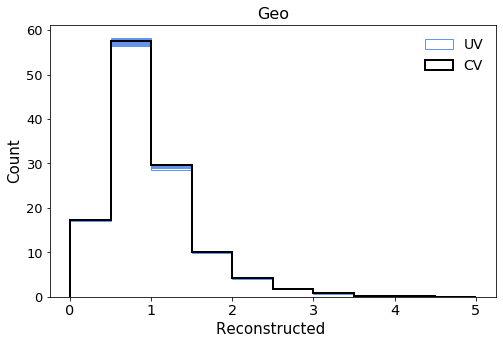

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


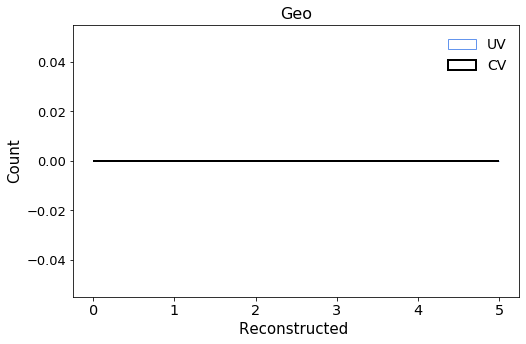

In [65]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    #current = (plt.hist(bin_centers, bins, histtype='step', 
    #                 weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    #print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [66]:
#will need to edit this if batching

nue_nue_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')   

In [67]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_geo.append(sum(masterlist[a]))

final_ncvs_nue_nue_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_nue_geo)):
    final_ns_nue_nue_geo[x] = np.concatenate((final_ns_nue_nue_geo[x][0], final_ns_nue_nue_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [68]:
if isRun3 == False:
    np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    #####################
    ###angleDiff########
    ####################

    np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection.csv')
    total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
    total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
    total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
    total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    #####################
    ###angleDiff########
    ####################

    np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               final_ns_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               final_ncvs_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_angleDiff_run3_usingSelection.csv')
    total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_angleDiff_run3_usingSelection.csv')
    total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_angleDiff_run3_usingSelection.csv')
    """
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               final_ns_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               final_ncvs_nue_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_leptonMom_run3_usingSelection.csv')
    total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_leptonMom_run3_usingSelection.csv')
    total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_leptonMom_run3_usingSelection.csv')
    """
    


## NUE_MC SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#full sample
if isRun3 == False:
    NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTun
elif isRun3 == True:
    NU   = '/neutrinoselection_filt_run3b_overlay'    +ls.APPEND #newTun
        

#actually fetch datasets
nue_mc  = uproot.open(ls.ntuple_path+NU+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_mc]

nue_variables = ["run", "sub", "evt", "swtrig_pre",            
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_mc  = nue_mc.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + nue_varMC, flatten=False)

['n_showers', 'reco_nu_vtx_sce_x', 'trkshrhitdist2', 'slnhits', 'shrsubclusters2', 'reco_nu_vtx_sce_z', 'CosmicIPAll3D', 'trk_energy_tot', 'swtrig_pre', 'npi0', 'shr_tkfit_dedx_V', 'trk_score_v', 'run', 'ccnc', 'nproton', 'shr_phi', 'shr_distance', 'reco_nu_vtx_sce_y', 'shr_energy_cali', 'shr_tkfit_nhits_U', 'shrsubclusters1', 'tksh_angle', 'selected', 'shr_px', 'flash_time', 'proton_e', 'shr_tkfit_nhits_V', 'shr_score', 'npion', 'shr_tkfit_npoints', 'shr_theta', 'category', 'shr_tkfit_nhits_Y', 'sub', 'n_showers_contained', 'contained_fraction', 'nslice', 'n_tracks_contained', 'shr_py', 'shrsubclusters0', 'evt', 'shr_tkfit_dedx_Y', 'shr_energy', 'tksh_distance', 'slnunhits', 'trk_energy', 'shr_pz', 'shr_tkfit_dedx_U', 'n_tracks', 'shr_energy_tot_cali', 'hits_ratio', 'nu_pdg', 'topological_score', 'shrmoliereavg', 'elec_e']


In [6]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_mc]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [7]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_mc]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
   # for ievt in range(df.shape[0]):
   #     reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
   #                          (df['weightsGenie'].iloc[ievt] == np.inf))
   #     df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [8]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)
if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    overlay_pot =  2.33652E21
elif isRun3 == True:
    beamon_pot = 5.014E20 #v5
    overlay_pot =  1.98937e+21    

nue_mc['pot_scale'] = beamon_pot/overlay_pot

In [9]:
nue_mc['totweight_data'] = nue_mc['pot_scale']*nue_mc['weightSplineTimesTuneTimesPPFX']

In [10]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [11]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [13]:
#This assumes the electron to be the leading shower

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

KeyboardInterrupt: 

In [12]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_mc]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  158.2874698638916


In [13]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [14]:
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']  

In [15]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_mc]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_e"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [16]:
#for i,df in enumerate(df_v):
#
#    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
#                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
#                                 & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
#                                 & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
#                                 & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
         

In [17]:
# add back the cosmic category, for background only
#df_v = [nue_mc]
#for i,df in enumerate(df_v):
#    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [16]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_mc]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [17]:
#Define signal catagories

#nue_mc["is_signal"] = nue_mc["category"] == 11

In [17]:
# Some quick clean up since some strange events get in there
nue_mc   = nue_mc.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_mc]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
   

In [21]:
#df_v = [nue_mc]
#for i,df in enumerate(df_v):
#    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
#    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
#    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

Set up complete. Set up BDT for selection.

In [18]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [19]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
if isRun3 == False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3 == True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')

In [20]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_mc]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(748702, 125)


In [21]:
datasets_bdt = nue_mc

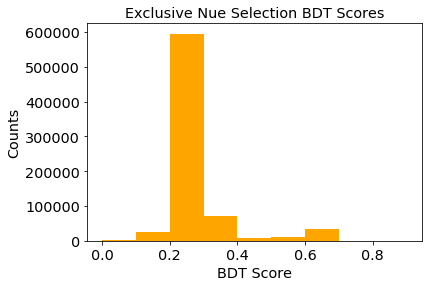

In [22]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [23]:
df_v = [nue_mc]
for i,df in enumerate(df_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1
   

In [24]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
NUE_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'

if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'    


SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

In [25]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1) & (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [26]:
test = np.nansum(nue_mc.query(SIGNAL_NUE_SEL_QUERY + " and ~(abs(nu_pdg) == 12 & ccnc == 0)")['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_mc.query(NUE_SEL_QUERY + "and ~(abs(nu_pdg) == 12 & ccnc == 0)")['totweight_data'])
print('total signal events = '+ str(test))


#more mc events

total signal events = 0.0
total signal events = 28.42180970452778


Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  748702
n_events/2 here =  374351.0

1.0
1
0
748702
{'nue_mc': 0.25203959042309876}
 reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 nue_mc
current sample is:  nue_mc
TEST
1
2
3
current_total  141858.23865102555
141858.238651025545550510287284851074218750000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  141858.23865102555
141858.238651025545550510287284851074218750000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))



current_total  141858.23865102555
141858.238651025545550510287284851074218750000000000000000000000000000000000000000
current_total_split  [666.9134411264108, 40703.382280427664, 78449.09939593596, 11925.572014240337, 10113.271519295165]
---------------------------STILL TOGETHER HERE (PAST PLOTTING)--------------------------------

-------------------NOT GOOD BY HERE------------------
current_total_hist  [1.33330058e+05 4.88353988e+03 2.01583270e+03 8.62121586e+02
 3.80372771e+02 1.92720915e+02 1.04093385e+02 5.29631162e+01
 2.40500098e+01 1.24858207e+01]
141858.23865102432

Returning
748702
0
{'nue_mc': 0.25203959042309876}
 reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 nue_mc
current sample is:  nue_mc
Had to return early (colour sorting).


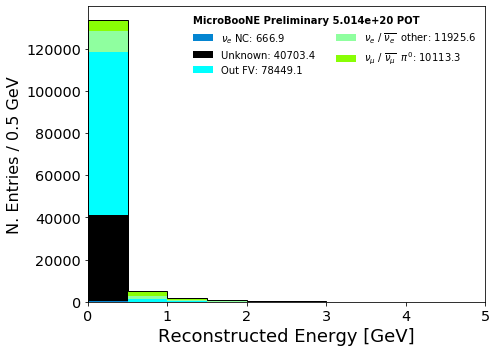

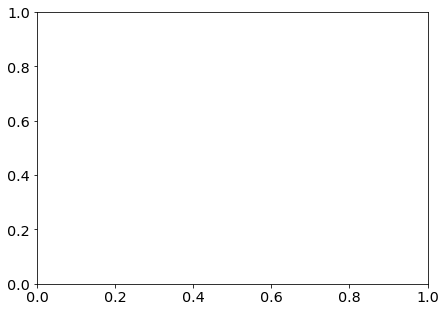

In [27]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/3.3))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    print(start)
    #print(end)
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]
    
    print(sample_set.shape[0])

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21

    # NU
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        #query= NUE_SEL_QUERY,
        query= "",
        currentsample = "nue_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
No handles with labels found to put in legend.


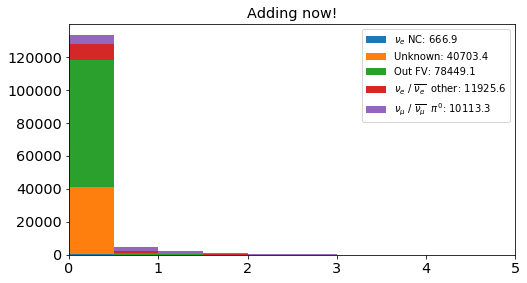

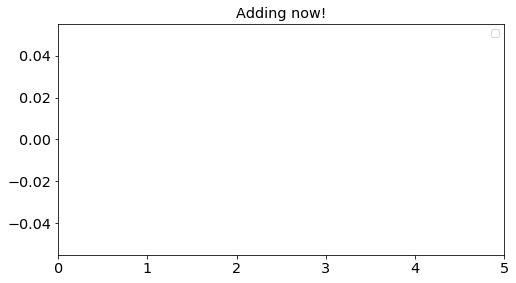

In [28]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [29]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

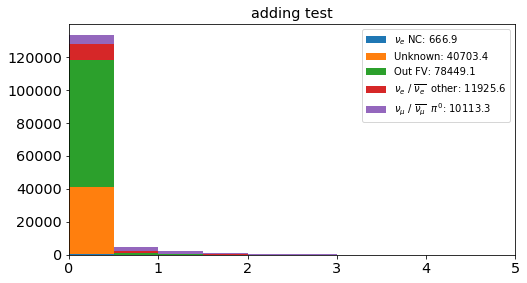

In [30]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 15])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 2])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [31]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[0.0, 1.4131513619358884, 1.043497126280272, 21.447586371723446]

SUMS
[666.9134411264099, 41370.29572155384, 119819.39511748929, 131744.96713172962, 141858.23865102488]
[40703.38228042743, 78449.09939593545, 11925.57201424033, 10113.27151929526]

Wanted List:
[40700.88819313965, 2.494087287777802, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[40700.88819313965, 2.494087287777802, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [32]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full trueE
    vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    #weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
    #weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')
elif isRun3 ==True:
    ######full trueE
    vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    #weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
    #weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')    

### Stat Errors

In [33]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
        
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  748702
n_events/2 here =  374351.0

1.0
1
{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_mc

LOOK HERE FOR DETSYS
None
err nue mc: 
[2.4139103  3.30324567 0.88933537 0.69876351 0.12704791 0.19057187
 0.06352396 0.         0.         0.        ]
detsys nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [ 8.840298   12.360728    3.0282679   2.6085773   0.5049338   0.70936024
  0.36964405  0.          0.          0.        ]
Returning
{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and

In [34]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

nue_mc_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_mc_stat_errs_selected = total_sels

total errs =  [2.4139102953444485, 3.3032456673134556, 0.8893353719690072, 0.6987635065470771, 0.12704791028128676, 0.19057186542193014, 0.06352395514064338, 0.0, 0.0, 0.0]

total selected =  [8.84029769897461, 12.36072826385498, 3.0282678604125977, 2.608577251434326, 0.504933774471283, 0.7093602418899536, 0.36964404582977295, 0.0, 0.0, 0.0]


In [35]:
if isRun3 == False:
    np.savetxt("nue_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               nue_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               nue_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
               nue_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
               nue_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')


    """
    #########################
    #####leptonMom###########
    ##########################
    """
    np.savetxt("nue_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
               nue_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
               nue_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:
    np.savetxt("nue_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               nue_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               nue_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_mc_stat_errs_full_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               nue_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               nue_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')


    """
    #########################
    #####leptonMom###########
    ##########################
    """
    np.savetxt("nue_mc_stat_errs_full_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               nue_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_stat_errs_selected_full_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               nue_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

### Sys Errors

In [36]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  748702
n_events/2 here =  374351.0

1.0
1
{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
extra query added.
      0     1     2     3     4     5     6     7     8     9    ...   590  \
0     341   807   578   486   254    80   280   460   352   101  ...   713   
1    1068  1149   985  1076   947  1072  1173  1062  1055  1155  ...  1046   
2     469   459   523   470   483   548   513   553   525   481  ...   472   
3    1045  1052  1141  1079  1132  1157  1156  1114  1143  

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 8.8402977  12.36072922  3.02826691  2.60857773  0.50493431  0.70936012
  0.36964417  0.          0.          0.        ]


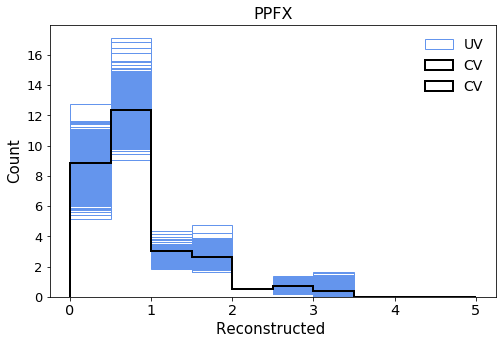

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


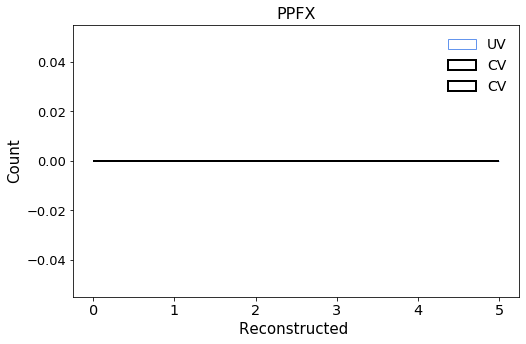

In [37]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [38]:
#will need to edit this if batching

nue_mc_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')    

In [39]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_mc_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [40]:
if isRun3 == False:
    np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')


    total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_nue_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDif_usingSelectionf.csv')
    total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')


    total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               final_ns_nue_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv", 
               final_ncvs_nue_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv')
    total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_run3_usingSelectionf.csv')
    total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_run3_usingSelection.csv')
    """
    """
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               final_ns_nue_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv", 
               final_ncvs_nue_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    """

In [41]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }  


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  748702
n_events/2 here =  374351.0

1.0
1
{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
extra query added.
      0     1     2    3     4     5     6     7    8     9    ...   590  \
0    1905  1369  2393  248   961   221   836  1896  205   421  ...   142   
1      88  1373   696  557  1204  2317  1122   798  844  1415  ...   941   
2     916   614  1004  687  1209   470   789   514  356  1354  ...  1158   
3    1288  1030  1135  459   894   281   715  1128  268   756  ... 

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 8.8402977  12.36072922  3.02826691  2.60857773  0.50493431  0.70936012
  0.36964417  0.          0.          0.        ]


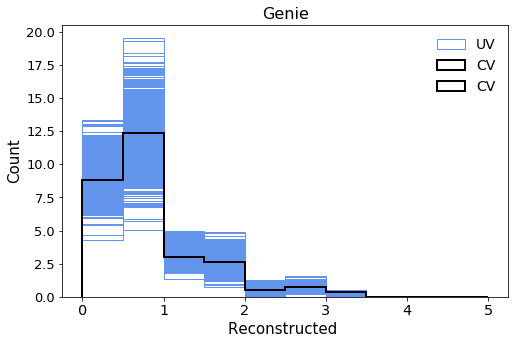

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


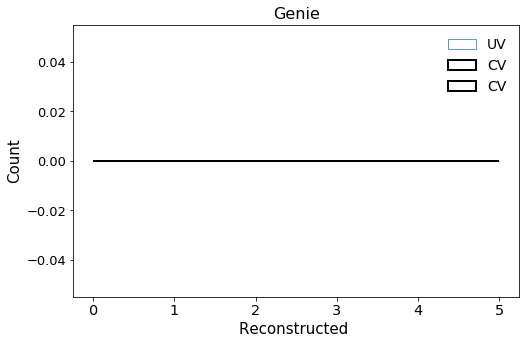

In [42]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [43]:
#will need to edit this if batching

nue_mc_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')   

In [44]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_genie.append(sum(masterlist[a]))

final_ncvs_nue_mc_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)

In [45]:
if isRun3 == False:
    np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_nue_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_nue_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_nue_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_nue_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_nue_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """

In [46]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
#batch_size = 40000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
        
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  748702
n_events/2 here =  374351.0
weightsReint
1.0
1
{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
extra query added.
      0     1     2     3     4     5     6     7     8     9    ...   990  \
0     928   779  1180  1006   897   951   895   941  1082   962  ...   861   
1    1038  1094   784   998  1020  1043  1117  1042   933  1004  ...  1122   
2     944   846  1081  1009   908   974   976   961  1077   959  ...   932   
3    1016  1010  1068   990  1057   986   902  

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 8.8402977  12.36072922  3.02826691  2.60857773  0.50493431  0.70936012
  0.36964417  0.          0.          0.        ]


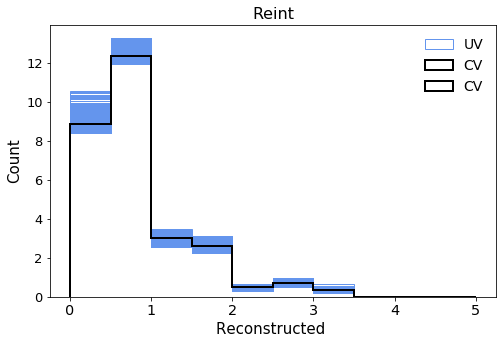

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


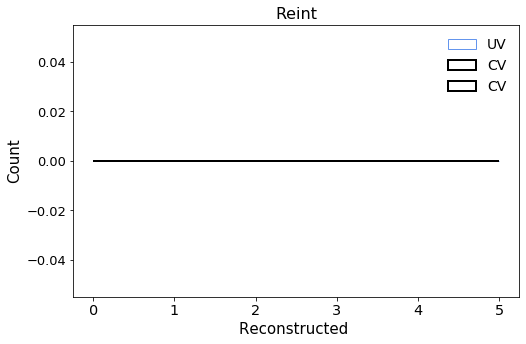

In [47]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [48]:
#will need to edit this if batching

nue_mc_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')    

In [49]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_reint.append(sum(masterlist[a]))

final_ncvs_nue_mc_reint = sum(n_cv_tots)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)


In [50]:
if isRun3 == False:
    np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """

    #################
    ###angleDiff#####
    #################

    np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_nue_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDif_usingSelectionf.csv", 
               final_ncvs_nue_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """

    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_run3_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """

    #################
    ###angleDiff#####
    #################

    np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_nue_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDif_usingSelection_run3.csv", 
               final_ncvs_nue_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """

    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_nue_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_nue_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """
        

In [51]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
#batch_size = 20000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
        
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  748702
n_events/2 here =  374351.0
1.0
2
{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_mc': 0.25203959042309876}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
dict_keys(['CV', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
[ 8.8402977  12.36072922  3.02826691  2.60857773  0.50493431  0.70936012
  0.36964417  0.          0.          0.        ]


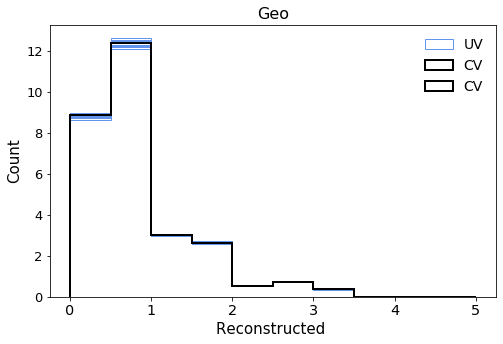

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
dict_keys(['CV'])
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


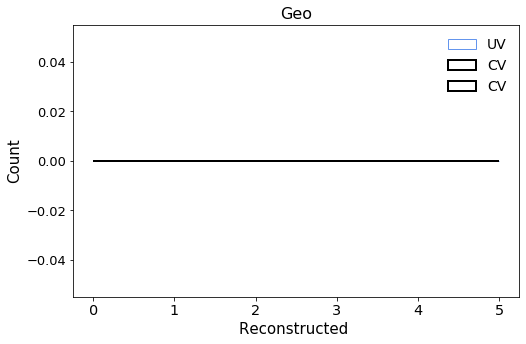

In [52]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 
    print(detvar_dicts[j].keys())


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                    weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                    weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)



    plt.show()

In [53]:
#will need to edit this if batching

nue_mc_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)
if isRun3 == False:
    nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')    

In [54]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_geo.append(sum(masterlist[a]))

final_ncvs_nue_mc_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_mc_geo)):
    final_ns_nue_mc_geo[x] = np.concatenate((final_ns_nue_mc_geo[x][0], final_ns_nue_mc_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [55]:
if isRun3 == False:
    np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    #####################
    ###angleDiff########
    ####################

    np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection.csv')
    total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
    total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
    total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
    total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    #####################
    ###angleDiff########
    ####################

    np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_nue_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """
        

## NUE_DIRT SAMPLE

In [37]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
#full sample
#DRT  = 'neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
if isRun3 == False:
    DRT  = 'prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'        +ls.APPEND
elif isRun3 == True:
    DRT  = 'neutrinoselection_filt_run3b_dirt_overlay'        +ls.APPEND

#actually fetch datasets
nue_dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_dirt]

nue_variables = ["run", "sub", "evt", "swtrig_pre",             
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_dirt = nue_dirt.pandas.df(nue_variables+nue_varMC + WEIGHTS + SYSTEMATICS + PPFX, flatten=False)

['swtrig_pre', 'tksh_distance', 'evt', 'shr_tkfit_npoints', 'slnunhits', 'shr_tkfit_nhits_U', 'nproton', 'CosmicIPAll3D', 'topological_score', 'npion', 'shr_score', 'ccnc', 'tksh_angle', 'shrsubclusters2', 'reco_nu_vtx_sce_z', 'slnhits', 'elec_e', 'n_showers_contained', 'shr_energy_tot_cali', 'shr_px', 'shr_pz', 'reco_nu_vtx_sce_y', 'shr_distance', 'shr_tkfit_dedx_U', 'selected', 'flash_time', 'shr_phi', 'contained_fraction', 'run', 'shr_energy_cali', 'n_tracks', 'trk_energy', 'shr_tkfit_dedx_Y', 'shr_tkfit_nhits_V', 'hits_ratio', 'shrmoliereavg', 'nu_pdg', 'trk_energy_tot', 'reco_nu_vtx_sce_x', 'sub', 'proton_e', 'shr_tkfit_nhits_Y', 'trkshrhitdist2', 'shrsubclusters0', 'shr_py', 'shr_tkfit_dedx_V', 'n_showers', 'shrsubclusters1', 'n_tracks_contained', 'shr_theta', 'nslice', 'npi0', 'shr_energy', 'category', 'trk_score_v']


In [38]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_dirt]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [39]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_dirt]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [40]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)

if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    dirt_pot =  1.42143e+21
    scalingDRT = 0.65 #0.35
elif isRun3 == True:
    beamon_pot = 5.014E20
    dirt_pot =  1.03226e+21
    scalingDRT = 0.45 

nue_dirt['pot_scale'] = (beamon_pot/dirt_pot)*scalingDRT

In [41]:
nue_dirt['totweight_data'] = nue_dirt['pot_scale']*nue_dirt['weightSplineTimesTuneTimesPPFX']

In [42]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [43]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [12]:
#This assumes the electron to be the leading shower

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

KeyboardInterrupt: 

In [44]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_dirt]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  37.393619775772095


In [45]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [46]:
df_v = [nue_dirt]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']  

In [47]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_dirt]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_e"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [48]:
#for i,df in enumerate(df_v):#

#    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
#                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
#                                 & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
#                                 & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
#                                 & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
         

In [49]:
# add back the cosmic category, for background only
#df_v = [nue_dirt]
#for i,df in enumerate(df_v):
#    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [50]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [51]:
#Define signal catagories

#nue_dirt["is_signal"] = nue_dirt["category"] == 11

In [52]:
# Some quick clean up since some strange events get in there
nue_dirt   = nue_dirt.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
   

Set up complete. Set up BDT for selection.

In [53]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [54]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
if isRun3 == False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3 == True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')    

In [55]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_dirt]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(389264, 108)


In [56]:
datasets_bdt = nue_dirt

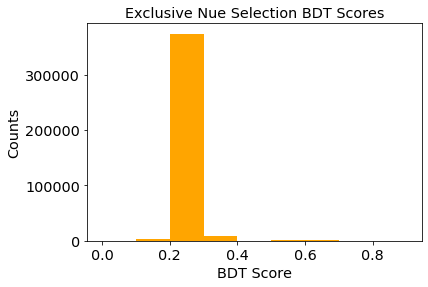

In [57]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [58]:
df_v = [nue_dirt]
for i,df in enumerate(df_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1

In [59]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
NUE_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'

if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'    

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

In [60]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)& (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [61]:
test = np.nansum(nue_dirt.query(SIGNAL_NUE_SEL_QUERY )['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_dirt.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))


total signal events = 0.0
total signal events = 0.2774351837779949


Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  389264
n_events/2 here =  194632.0

1.0
1
{'nue_dirt': 0.21857865266502624}
 reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 nue_dirt
current sample is:  nue_dirt
TEST
1
2
3
current_total  83513.06663857345
83513.066638573451200500130653381347656250000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  83513.06663857345
83513.066638573451200500130653381347656250000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  83513.06663857345
83513.066638573451200500130653381347656250000000000000000000000000000000000000000
current_total_split  [25390.439738226418, 58122.62690034703]
---------------------------STILL TOGETHER HERE (PAST PLOTTING)--------------------------------

-------------------NOT GOOD BY HERE------------------
current_total_hist  [8.29118012e+04 5.17157168e+02 5.84049430e+0

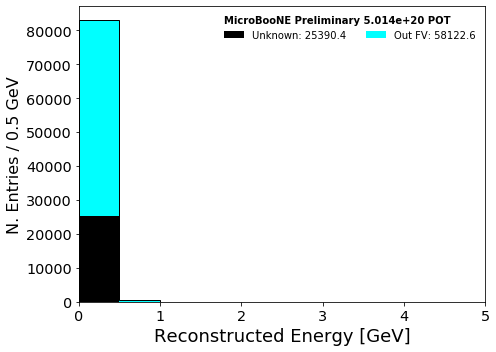

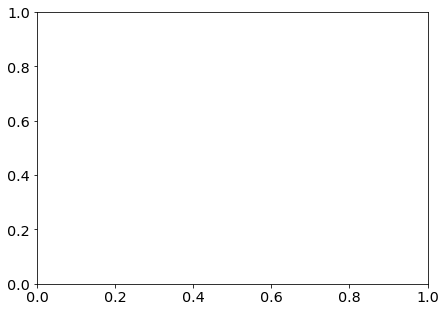

In [62]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        # This is the POT scaling factor for dirt sample
        dirtratio = pot/1.42143e+21
        # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45

    # NU
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        #query= NUE_SEL_QUERY,
        query= "",
        currentsample = "nue_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
No handles with labels found to put in legend.


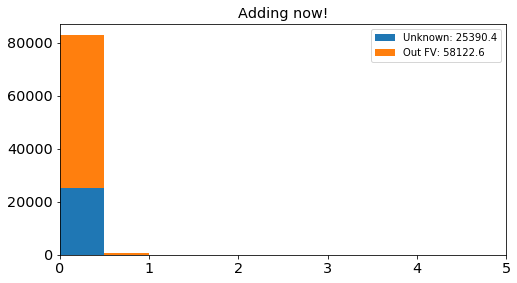

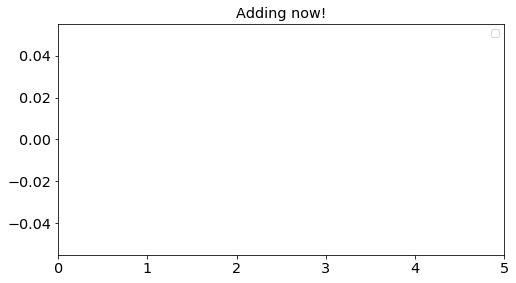

In [63]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [64]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

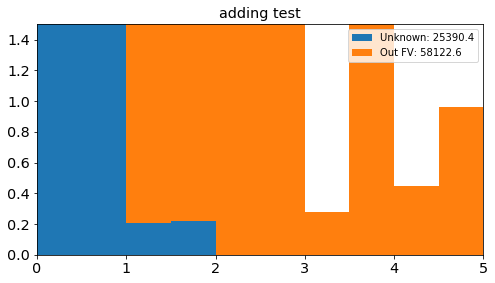

In [65]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 1.5])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 0.05])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [66]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 2

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[0.4487521041010041]

SUMS
[25390.439738226396, 83513.0666385733]
[58122.626900346906]

Wanted List:
[57525.01043597133, 513.9381571019621, 58.19713616652734, 14.50400869625446, 6.100875086849555, 1.6373953979709768, 0.28084432586911134, 1.5485361671380815, 0.4487521041010041, 0.960759328911081]

[57525.01043597133, 513.9381571019621, 58.19713616652734, 14.50400869625446, 6.100875086849555, 1.6373953979709768, 0.28084432586911134, 1.5485361671380815, 0.4487521041010041, 0.960759328911081]


In [67]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full trueE
    vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    #weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
    #weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')
elif isRun3 == True:
    ######full trueE
    vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    #weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    #weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')


### Stat Err

In [87]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        # This is the POT scaling factor for dirt sample
        dirtratio = pot/1.42143e+21
        # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  389264
n_events/2 here =  194632.0

1.0
1
{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_dirt

LOOK HERE FOR DETSYS
None
err nue dirt: 
[0.04777663 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
detsys nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0.27743518 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Returning
{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 1

In [88]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

nue_dirt_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_dirt_stat_errs_selected = total_sels

total errs =  [0.04777662740085818, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

total selected =  [0.27743518352508545, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [89]:
if isRun3 == False:
    np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               nue_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               nue_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')




    #########################
    #####angleDiff###########
    ##########################
    """
    np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_angleDiff_allselected_corrected.csv", 
               nue_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_angleDiff_allselected_corrected.csv", 
               nue_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')


    """
    #########################
    #####leptonMom###########
    ##########################
    """
    np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
               nue_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
               nue_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:
    np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               nue_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               nue_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')




    #########################
    #####angleDiff###########
    ##########################
    """
    np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_angleDiff_allselected_corrected_run3.csv", 
               nue_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_angleDiff_allselected_corrected_run3.csv", 
               nue_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')


    """
    #########################
    #####leptonMom###########
    ##########################
    """
    np.savetxt("nue_dirt_stat_errs_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               nue_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               nue_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

### Sys Errs

In [90]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  389264
n_events/2 here =  194632.0

1.0
1
{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
    0     1     2     3     4     5     6     7     8     9    ...   590  \
0  1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   

    591   592   593   594   595   596   597   598   599  
0  1000  1000  1000  1000  1000  1000  1000  1000  1000  

[1 rows x 600 columns]
    0     1     2     3     4     5     6     7     8     9    ...   590  \
0  1000  1000  1000

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0.27743518 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


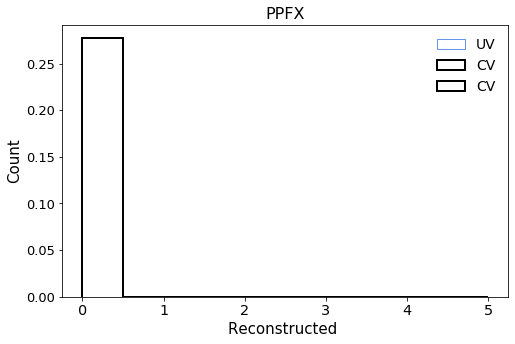

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


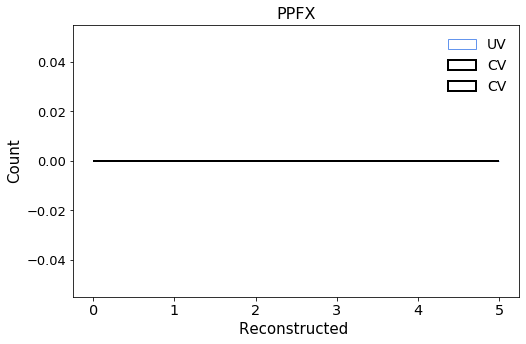

In [91]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [92]:
#will need to edit this if batching

nue_dirt_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')    

In [93]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_dirt_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [94]:
if isRun3 == False:
    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')


    """
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """ 
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')


    """
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """ 
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """


In [95]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse = 500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  389264
n_events/2 here =  194632.0

1.0
1
{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
    0     1     2     3     4     5     6     7     8     9    ...   590  \
0  1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   

    591   592   593   594   595   596   597   598   599  
0  1000  1000  1000  1000  1000  1000  1000  1000  1000  

[1 rows x 600 columns]
    0     1     2     3     4     5     6     7     8     9    ...   590  \
0  1000  1000  1000

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0.27743518 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


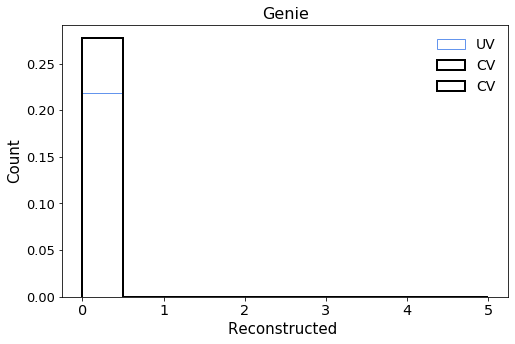

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


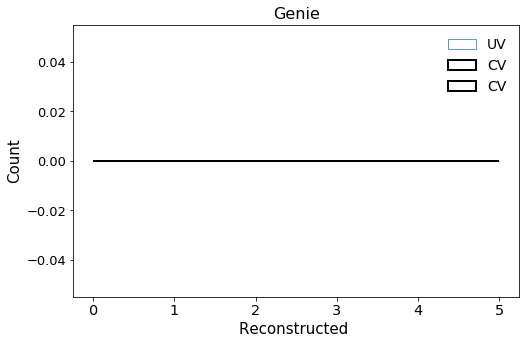

In [96]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [97]:
#will need to edit this if batching

nue_dirt_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
     

In [98]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_genie.append(sum(masterlist[a]))

final_ncvs_nue_dirt_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
print(total_genie_df_splines)


    0     1     2     3     4     5     6     7     8     9    ...   590  \
0  1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   

    591   592   593   594   595   596   597   598   599  
0  1000  1000  1000  1000  1000  1000  1000  1000  1000  

[1 rows x 600 columns]
entry
312740    0.47448
Name: reco_e, dtype: float32
entry
312740    0.218579
Name: weightSpline, dtype: float32


In [99]:
if isRun3 == False:
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """


In [100]:
########### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  389264
n_events/2 here =  194632.0
weightsReint
1.0
1
{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Empty DataFrame
Columns: []
Index: [0]
Returning
--------------------------

{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0.27743518 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


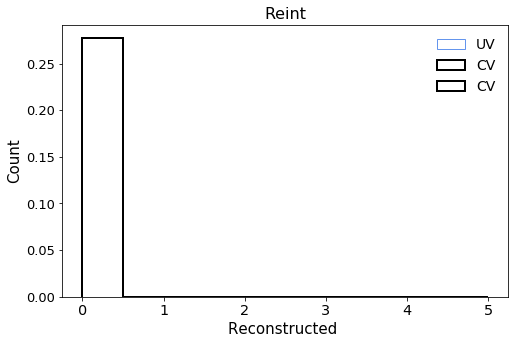

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


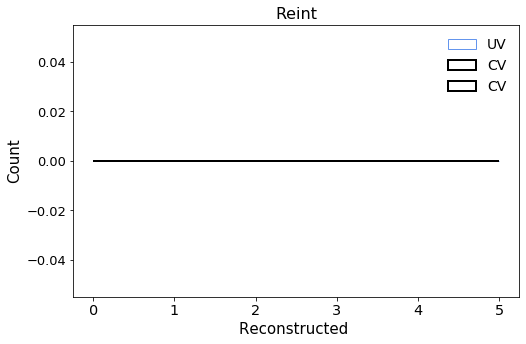

In [101]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)



    plt.show()

In [102]:
#will need to edit this if batching

nue_dirt_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [103]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_reint.append(sum(masterlist[a]))

final_ncvs_nue_dirt_reint = sum(n_cv_tots)
print(final_ncvs_nue_dirt_reint)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
print(total_reint_df_splines)


[0.27743518 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Empty DataFrame
Columns: []
Index: [0]
entry
312740    0.47448
Name: reco_e, dtype: float32
entry
312740    0.277435
Name: weightSplineTimesTuneTimesPPFX, dtype: float32


In [104]:
if isRun3 == False:
    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')


    """
    #################
    ###angleDiff#####
    #################

    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')


    """
    #################
    ###angleDiff#####
    #################

    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection._run3csv')
    """
    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """

In [105]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  389264
n_events/2 here =  194632.0
1.0
2
{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5 and BDT_score > 0.575& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_dirt': 0.21857865266502624}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0.27743518 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


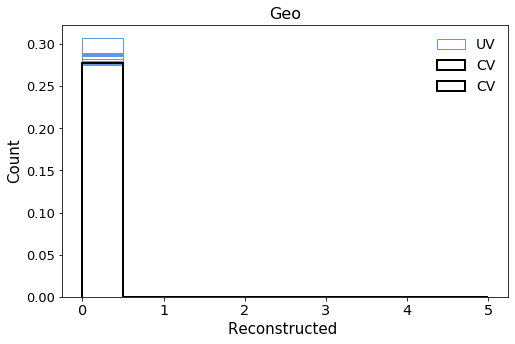

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


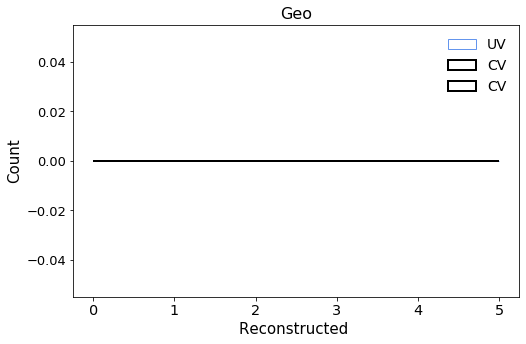

In [106]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [107]:
#will need to edit this if batching

nue_dirt_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [108]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_geo.append(sum(masterlist[a]))

final_ncvs_nue_dirt_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_dirt_geo)):
    final_ns_nue_dirt_geo[x] = np.concatenate((final_ns_nue_dirt_geo[x][0], final_ns_nue_dirt_geo[x][1]))
    
    
print(final_ns_nue_dirt_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
print(total_geo_df_splines)

[0.2819254  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.28568129 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
entry
312740    0.277435
Name: weightSplineTimesTuneTimesPPFX, dtype: float32


In [109]:
if isRun3 == False:
    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')

    """
    #####################
    ###angleDiff########
    ####################

    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDif_usingSelectionf.csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_angleDif_usingSelectionf.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')

    """
    #####################
    ###angleDiff########
    ####################

    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDif_usingSelection_run3.csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_angleDif_usingSelection_run3.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """


## NUE_EXT SAMPLE

In [ ]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
#full sample
if isRun3 == False:
    EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
elif isRun3 == True:
    EXT  = '/neutrinoselection_filt_run3b_beamoff'         +ls.APPEND    

#actually fetch datasets
nue_ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_ext]

nue_variables = ["run", "sub", "evt", "swtrig_pre",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_ext  = nue_ext.pandas.df(nue_variables + nue_varMC, flatten=False)

['npi0', 'shr_score', 'reco_nu_vtx_sce_z', 'shrsubclusters1', 'shr_py', 'trk_energy', 'shr_pz', 'contained_fraction', 'npion', 'shr_px', 'shr_energy_cali', 'tksh_distance', 'shr_energy_tot_cali', 'shrmoliereavg', 'trk_score_v', 'category', 'trkshrhitdist2', 'tksh_angle', 'reco_nu_vtx_sce_x', 'slnhits', 'n_tracks', 'shr_distance', 'CosmicIPAll3D', 'run', 'shr_tkfit_npoints', 'selected', 'nslice', 'nproton', 'shr_phi', 'shrsubclusters2', 'topological_score', 'swtrig_pre', 'trk_energy_tot', 'flash_time', 'nu_pdg', 'proton_e', 'sub', 'shr_theta', 'shr_tkfit_nhits_V', 'shr_energy', 'n_showers', 'n_showers_contained', 'shr_tkfit_dedx_Y', 'shr_tkfit_dedx_V', 'slnunhits', 'shrsubclusters0', 'reco_nu_vtx_sce_y', 'shr_tkfit_dedx_U', 'shr_tkfit_nhits_U', 'shr_tkfit_nhits_Y', 'evt', 'ccnc', 'elec_e', 'n_tracks_contained', 'hits_ratio']


In [29]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)

if isRun3 == False:
    # The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
    extratio  = 5268051/9199232.74
    # We scale down the EXT to account for neutrino occupancy
    scalingEXT = 0.98
elif isRun3 == True:
    extratio  = 10363728.0/32878305.25
    scalingEXT = 0.98


nue_ext['pot_scale'] = extratio * scalingEXT

In [30]:
nue_ext['totweight_data'] = nue_ext['pot_scale']

In [31]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [32]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [10]:
#This assumes the electron to be the leading shower
df_v = [nue_ext]

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

KeyboardInterrupt: 

In [33]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_ext]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    #puppa_shw = []
    #puppa_prt = [] 
    #puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        #N_recoShowers = 0
        #N_recoProtons = 0
        #N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            #protonCut  = (passPIDCut & passTrkCut) 
            #muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            #N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            #N_recoProtons = np.count_nonzero(protonCut)
            #N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        #puppa_shw.append(N_recoShowers)    
        #puppa_prt.append(N_recoProtons)
        #puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    #df['N_recoShowers']   = puppa_shw
    #df['N_recoProtons']   = puppa_prt
    #df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    #df['protonenergy']    = trk_energy_proton_sel
    #df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    #df['protontheta']  = trk_theta_proton_sel
    #df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
#for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
#    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  88.06618857383728


In [34]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [35]:
df_v = [nue_ext]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [36]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_ext]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_e"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    #df["extdata"] = np.zeros_like(df["shr_energy"])
nue_ext["extdata"] = np.ones_like(nue_ext["shr_energy"])

In [119]:
#for i,df in enumerate(df_v):

#    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
#                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
#                                 & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
#                                 & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
#                                 & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
         

In [120]:
# add back the cosmic category, for background only
#df_v = [nue_ext]
#for i,df in enumerate(df_v):
#    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [37]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts

df_v = [nue_ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359
        
#BDT 

In [122]:
#Define signal catagories

#nue_ext["is_signal"] = nue_ext["category"] == 11

Set up complete. Set up BDT for selection.

In [38]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [39]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})

if isRun3 == False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3 == True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')    

In [40]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_ext]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(3211097, 89)


In [41]:
datasets_bdt = nue_ext

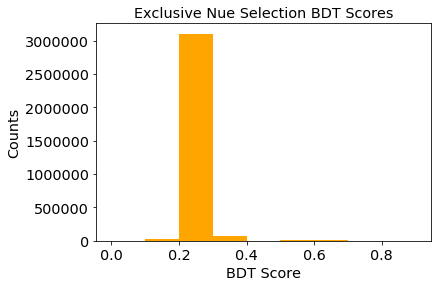

In [42]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [43]:
df_v = [nue_ext]
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1
            

In [44]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#No true selection here as this is data

if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'    

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

In [45]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where( (df.swtrig_pre==1)&(df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [46]:
test = np.nansum(nue_ext.query(SIGNAL_NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_ext.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))


total signal events = 0.0
total signal events = 4.324746883357073


Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  3211097
n_events/2 here =  1605548.0

1.0
1
{'ext': 0.3089104916683624}
 reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 nue_ext
1
2
3
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
total after ext 991914.9867625199
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
current_total_split  []
---------------------------STILL TOGETHER HERE (PAST PLOTTING)--------------------------------

-------------------NOT GOOD BY HERE------------------
current_total_hist  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
n_ext  [9.85753149e+05 5.29719711e+03 5.33797330e+02 1.55073067e+02
 7.16672341e+01 3.92316324e+01 2.285

No handles with labels found to put in legend.



Returning
{'ext': 0.3089104916683624}
 reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 nue_ext
1
2
3
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
total after ext 0.0
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
current_total_split  []
---------------------------STILL TOGETHER HERE (PAST PLOTTING)--------------------------------

-------------------NOT GOOD BY HERE------------------
current_total_hist  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
n_ext  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Returning


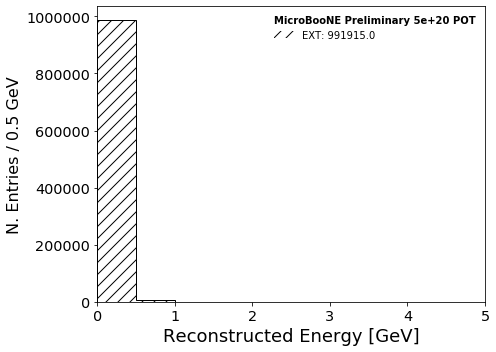

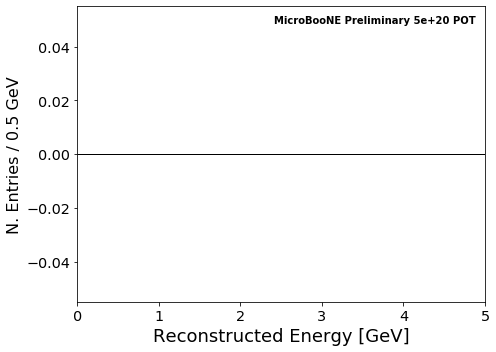

In [47]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_ext.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
#batch_size = n_events
batch_size = n_events
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_ext.iloc[start:end]

    samples = {
        "nue_ext": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        # The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
        extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
        # We scale down the EXT to account for neutrino occupancy
        scalingEXT = 0.98
    elif isRun3 == True:
        pot =  5e+20
        extratio  = 10363728.0/32878305.25
        scalingEXT = 0.98
    

    # NU
    weights = { #full sample mc = 0.38  
                "ext" : extratio * SPLIT * scalingEXT, #set0 
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        #query= NUE_SEL_QUERY,
        query= "",
        currentsample = "nue_ext",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


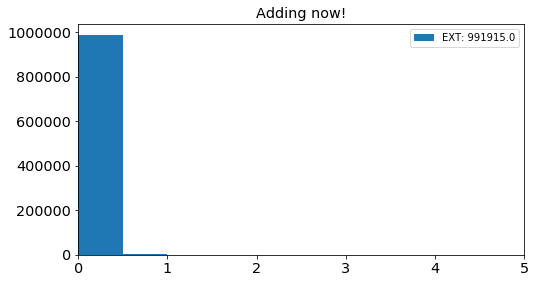

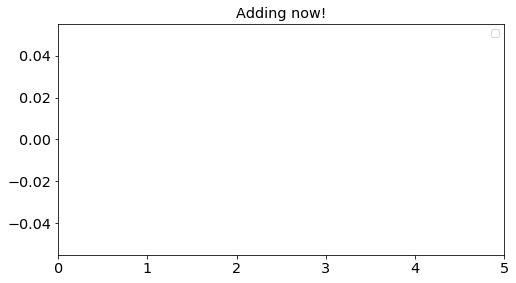

In [48]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i],
                weights=list(weightss[i]),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [49]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = np.concatenate(varss)
weightss_tot = np.concatenate(weightss)

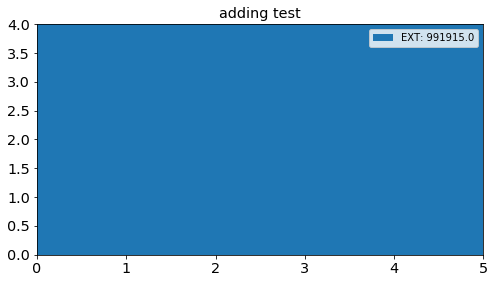

In [50]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}


labels = labss


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 4])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 0.8])

nue_stacked = nue_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [51]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 2

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [52]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full trueE
    vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    #weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_leptonMom_usingSelection_recoCut_3GeV.csv')
    #weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection_recoCut_3GeV.csv')
elif isRun3 == True:
    ######full trueE
    vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    #weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_leptonMom_usingSelection_recoCut_3GeV_run3.csv')
    #weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection_recoCut_3GeV_run3.csv')


### Stat Errs

[1.47050109 1.47050109 0.         0.         0.         0.
 0.         0.         0.         0.        ]


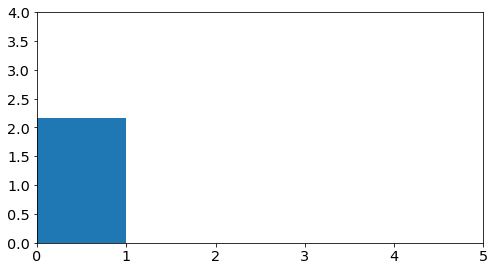

In [138]:
#A poisson uncertainty is assumed for beam off (see krishan's thesis p.182)

nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 4])


nue_stacked = nue_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)


nue_ext_stat_errs = np.sqrt(nue_stacked[0])

print(nue_ext_stat_errs)

In [139]:
if isRun3 == False:
    np.savetxt("nue_ext_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               nue_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_ext_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_07Jul.csv", 
    #           nue_ext_stat_errs_selected,
    #           delimiter =", ", 
    #           fmt ='% s')


    """
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:
    np.savetxt("nue_ext_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               nue_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_ext_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_07Jul.csv", 
    #           nue_ext_stat_errs_selected,
    #           delimiter =", ", 
    #           fmt ='% s')


    """
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
        

## NUE_DATA SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
#full sample
if isRun3 == False:
    BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
elif isRun3 == True:
    BNB  = '/neutrinoselection_filt_run3b_beamon_beamgood' +ls.APPEND    

#actually fetch datasets
nue_data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_data]

nue_variables = ["run", "sub", "evt", "swtrig_pre",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_data = nue_data.pandas.df(nue_variables + nue_varMC , flatten=False)

['category', 'flash_time', 'proton_e', 'shrmoliereavg', 'shr_tkfit_dedx_U', 'ccnc', 'sub', 'shr_energy_cali', 'shr_py', 'n_tracks', 'shrsubclusters1', 'elec_e', 'topological_score', 'shrsubclusters2', 'shr_phi', 'selected', 'n_showers', 'run', 'hits_ratio', 'shr_tkfit_dedx_Y', 'shr_tkfit_nhits_V', 'n_showers_contained', 'shr_energy_tot_cali', 'shr_theta', 'CosmicIPAll3D', 'reco_nu_vtx_sce_z', 'nu_pdg', 'reco_nu_vtx_sce_x', 'shr_px', 'slnhits', 'trkshrhitdist2', 'nslice', 'swtrig_pre', 'shr_distance', 'trk_energy', 'evt', 'shrsubclusters0', 'shr_tkfit_npoints', 'shr_tkfit_dedx_V', 'contained_fraction', 'trk_score_v', 'reco_nu_vtx_sce_y', 'slnunhits', 'npion', 'npi0', 'shr_tkfit_nhits_Y', 'shr_score', 'shr_tkfit_nhits_U', 'tksh_angle', 'shr_pz', 'trk_energy_tot', 'n_tracks_contained', 'nproton', 'shr_energy', 'tksh_distance']


In [6]:
nue_data['pot_scale'] = [1 for x in range(len(nue_data))]

In [7]:
nue_data['totweight_data'] = nue_data['pot_scale']

In [8]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [9]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [74]:
#This assumes the electron to be the leading shower
df_v = [nue_data]

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [10]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_data]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  85.8645339012146


In [11]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [12]:
df_v = [nue_data]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [13]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_data]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"]+ df["proton_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    #df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
nue_data["bnbdata"] = np.ones_like(nue_data["shr_energy"])


In [14]:
#for i,df in enumerate(df_v):

#    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
#                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
#                                 & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
#                                 & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
#                                 & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
         

In [16]:
# add back the cosmic category, for background only
#df_v = [nue_data]
#for i,df in enumerate(df_v):
#    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [95]:
#Define signal catagories

#nue_data["is_signal"] = nue_data["category"] == 11

Set up complete. Now on to BDT.

In [14]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [15]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})

if isRun3 == False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3 == True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')
    

In [16]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_data]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(1104349, 95)


In [17]:
datasets_bdt = nue_data

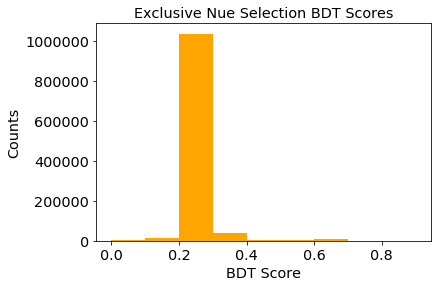

In [18]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [19]:
df_v = [nue_data]
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1
   

In [20]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#No truth selection as this data

if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'    

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

In [21]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)& (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [22]:
test = np.nansum(nue_data.query(SIGNAL_NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_data.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 0
total signal events = 163


Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  1104349
n_events/2 here =  552174.0

1.0
1
 reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 nue_data


No handles with labels found to put in legend.


1
2
3
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
current_total_split  []
---------------------------STILL TOGETHER HERE (PAST PLOTTING)--------------------------------

-------------------NOT GOOD BY HERE------------------
current_total_hist  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0

Returning
 reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 nue_data
1
2
3
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  0.0
0.000000000000

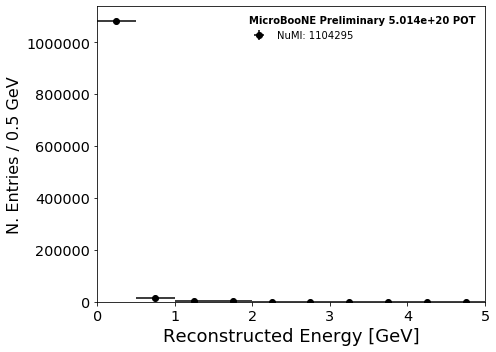

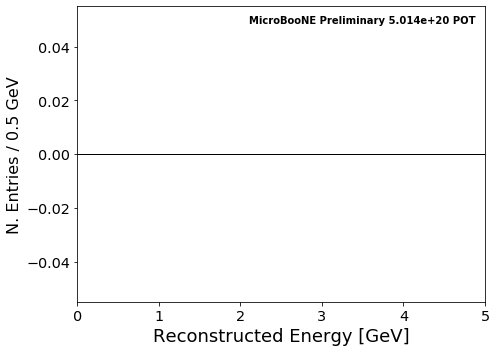

In [23]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_data.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_data.iloc[start:end]

    samples = {
        "nue_data": sample_set 
    }

    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 
    elif isRun3 == True:
        pot =  5.014e+20 
        
    weights = {  
                }
    
    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        #query= NUE_SEL_QUERY,
        query= "",
        currentsample = "nue_data",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

[array([1082919,   15497,    3615,    1229,     548,     239,     127,
            62,      35,      24]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


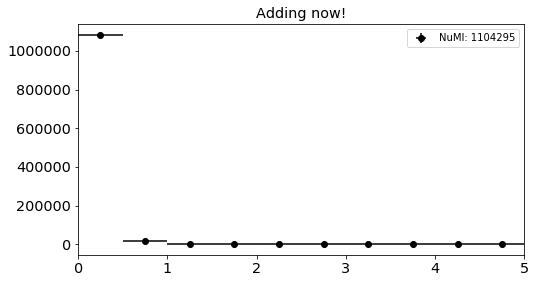

In [24]:
from matplotlib import gridspec

#for i in range(int(n_events/batch_size)+1):
for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    current_bincenters =  np.arange(0.25, 5.25, 0.5)
    current_bin_size = 0.5
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff
    #current_bincenters =  np.arange(-0.9, 1.1, 0.2)
    #current_bin_size = 0.25
    
    print(varss)
    
    nue_ax1.errorbar(
                current_bincenters,
                varss[i],
                xerr=current_bin_size/2,
                yerr=weightss[i],
                fmt='ko',
                label="NuMI: %i" % sum(varss[i]) if sum(varss[i]) else "")
    
    plt.title("Adding now!")
    plt.legend()

In [25]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = sum(varss)
print(weightss[0][0])
#sum errors? will need to change if splitting data
weightss_tot = weightss[0][0]

[1040.6339414   124.48694711   60.12487006   35.05709629   23.40939982
   15.45962483   11.26942767    7.87400787    5.91607978    4.89897949]


[1082919   15497    3615    1229     548     239     127      62      35
      24]


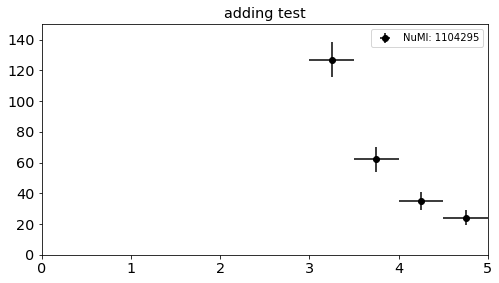

In [26]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}


labels = labss

nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 150])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 33])

print(varss_tot)

nue_ax1.errorbar(
            current_bincenters,
            varss_tot,
            xerr=current_bin_size/2,
            yerr=weightss_tot,
            fmt='ko',
            label="NuMI: %i" % sum(varss_tot) if sum(varss_tot) else "")


plt.title("adding test")
plt.legend()

In [27]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full trueE
    vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    #weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
    #weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')
elif isRun3 == True:
    ######full trueE
    vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    #weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    ########leptonMom
    #vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    #weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    

## NUMU_MC SAMPLE (and Nue)

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#full sample
if isRun3 == False:
    NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
elif isRun3 == True:
    NU   = '/neutrinoselection_filt_run3b_overlay'    +ls.APPEND   

#actually fetch datasets
numu_mc  = uproot.open(ls.ntuple_path+NU+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_mc]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", "trk_score_v", #"trk_pfp_id",
        "category", "ccnc", "swtrig_pre", "trk_len_v",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
        "reco_e", "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score", "proton_e", "elec_e",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

#redefine reco e to match nue?

['ccnc', 'run', 'trk_sce_end_y_v', 'mc_pdg', 'muon_e', 'true_e_visible', 'evnunhits', 'slnunhits', 'trk_len_v', 'interaction', 'elec_e', 'reco_nu_vtx_x', 'isVtxInFiducial', 'trk_sce_end_z_v', 'nu_pdg', 'CosmicIP', 'reco_nu_vtx_y', 'backtracked_pdg', 'sub', 'flash_pe', 'trk_range_muon_mom_v', 'CosmicDirAll3D', 'npion', 'slpdg', 'reco_nu_vtx_sce_x', 'trk_energy_tot', 'nproton', 'slnhits', 'npi0', 'shr_energy_tot_cali', 'slclustfrac', 'trk_energy_muon', 'trk_mcs_muon_mom_v', 'topological_score', '_opfilter_pe_veto', 'evt', '_opfilter_pe_beam', 'shr_tkfit_dedx_Y', 'reco_e', 'category', 'tksh_distance', 'proton_e', 'pi0_e', 'nmuon', 'nslice', 'trk_phi', 'pion_e', 'reco_nu_vtx_sce_z', 'trk_score_v', 'CosmicIPAll3D', 'n_showers_contained', 'reco_nu_vtx_z', 'trk_theta', 'trk_sce_end_x_v', 'trk_sce_start_x_v', 'pi0truth_elec_etot', 'reco_nu_vtx_sce_y', 'trk_llr_pid_score_v', 'swtrig_pre']


In [6]:
import time
s = time.time()

import pandas as pandas

mc_var   = numu_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + numu_varMC

# This needs modifications (add variables from above)
uproot_v = [numu_mc] 
var_v    = [mc_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_mc = CVDF

s2 = time.time()

print("runtime = ", s2-s)
#approx 25 min run time

trk_llr_pid_v  [[0.9051982] [] [] ... [] [] [0.96284807]]
trk_score_v  [[0.9768751] [] [] ... [] [] [1.0]]
Here:
trk_range_muon_mom_v  [[0.25889522] [] [] ... [] [] [0.5288412]]
trk_mcs_muon_mom_v  [[0.47899732] [] [] ... [] [] [0.46399802]]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


runtime =  1289.3017537593842


In [7]:
df_v = [numu_mc]
#print(df_v)
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [8]:
df_v = [numu_mc]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [9]:
#numu_mc.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and \
#reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and \
#n_muons_tot > 0 and n_showers_contained==0", inplace=True)
numu_mc.query("nu_e > 0 and nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 \
and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0", inplace=True)

In [10]:
s = time.time()

df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    
    
s2 = time.time()
print("runtime = ", s2-s)
#Run1 = 
#Run3 = 

runtime =  12.957957029342651


In [11]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']
    #print(df['trk_sce_start_x_v'])
    #print(df['reco_nu_vtx_sce_x'])
    #print(df['nu_pdg'])

In [12]:
df_v = [numu_mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

In [13]:
if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    overlay_pot =  2.33652E21
elif isRun3 == True:
    beamon_pot = 5.014E20
    overlay_pot =  1.98937e+21    

numu_mc['pot_scale'] = beamon_pot/overlay_pot

In [14]:
numu_mc['totweight_data'] = numu_mc['pot_scale']*numu_mc['weightSplineTimesTuneTimesPPFX']

In [15]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [16]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_5318/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  21.20923924446106


In [17]:
#numu_mc["is_signal"]   = numu_mc["category"] == 2
#print(numu_mc["is_signal"])

In [17]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [18]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [23]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    print(df['trk_mcs_muon_mom_v'])

entry
0                                              [0.27999988]
1                   [0.40099838, 14.999432, -3.4028235e+38]
3                                              [0.26700005]
7            [0.08299999, 0.25700024, 14.998431, 14.999432]
11                                             [0.32599935]
                                ...                        
914702                             [0.49199766, 0.30399963]
914720    [0.24700028, 0.06299995, 0.2380003, 0.12800008...
914722                               [1.2560071, 0.6829947]
914725                              [0.31199953, 14.999432]
914728                   [1.9420298, 0.13100009, 14.993429]
Name: trk_mcs_muon_mom_v, Length: 367083, dtype: object


In [17]:
#The selection query
#numu_mc.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 n_showers_contained==1 and shr_tkfit_dedx_Y<4 and tksh_distance<5", inplace=True)

In [19]:
"""
s = time.time()

for i,df in enumerate(df_v):
    df["muon_px"] = df["ccnc"].copy()
    df["muon_py"] = df["ccnc"].copy()
    df["muon_pz"] = df["ccnc"].copy()
    for j, row in df.iterrows():
        pdg_vector = df["mc_pdg"].loc[j][0]
        px_vector = df["mc_px"].loc[j]
        py_vector = df["mc_py"].loc[j]
        pz_vector = df["mc_pz"].loc[j]
        result = np.where(pdg_vector==13)[0]
        if np.size(result):
            df.loc[j, "muon_px"] = px_vector[result][0]
            df.loc[j, "muon_py"] = py_vector[result][0]
            df.loc[j, "muon_pz"] = pz_vector[result][0]   
            
    print(df["muon_px"])

print("")    
print("==========================")
s2 = time.time()
print("runetime = ", s2-s)
"""
df_v = [numu_mc]
#removeGenieTune = False
#for i,df in enumerate(df_v):
#    print(df['muon_momentum'])

#if track is stopped in fiducial volume
#    then use stoppingmom
#else
#    use other mom
    
#set up this new variable for each one in  the dataframe

#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_sce_end_z_v"].copy()
    for j, row in df.iterrows():
        if (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])

KeyboardInterrupt: 

In [19]:
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    #df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    #df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    #df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    #df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

In [19]:
numu_mc   = numu_mc.query('nu_e > 0.')
#numu_mc.query("nu_e > 0.", inplace=True)

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_mc]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

Set up complete. 

In [20]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

#nue = mc.query("(abs(nu_pdg) == 12 and ccnc == 0)") 
#nueMC = mc.query("(abs(nu_pdg) == 14 & ccnc == 0)")
##CHANGE
numu_nue   = numu_mc.query("(abs(nu_pdg) == 12 & ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55)")



samples = {
    "numu_mc"  : numu_mc,
    "numu_nue" : numu_nue
}


if isRun3 == False:
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
elif isRun3 == True:
    pot =  5.014e20
    mcratio  = pot/1.98937e+21
        
#nueratio  = pot/2.37838e+22

SPLIT = 1.0
scaling = 1

weights = { "numu_mc"  : mcratio  * SPLIT * scaling,
            "numu_nue"  : mcratio  * SPLIT * scaling   
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'numu_mc': 0.25203959042309876, 'numu_nue': 0.25203959042309876}


In [21]:
dfmc_v = [numu_mc, numu_nue]

for i,df in enumerate(dfmc_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
                                 & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)

    df.loc[ (df['is_signal']== True), 'category' ] = 1

/tmp/ipykernel_5318/2774016237.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
#New categories

for i,df in enumerate(dfmc_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)&  (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["nue_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_CC_Npi0']== True), 'category' ] = 3
    df["nue_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['nue_CC_0pi0']== True), 'category' ] = 4
    
    df["nue_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 5
    df["nue_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 6
    
    df["numubar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['numubar_1eNp']== True), 'category' ] = 7
    df["numu_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1), True, False)
    df.loc[ (df['numu_NC']== True), 'category' ] = 8
    
    df["numu_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['numu_CCother']== True), 'category' ] = 9
    #df["numu_CCother_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) & (df.npi0==0), True, False)
    #df.loc[ (df['numu_CCother_0pi0']== True), 'category' ] = 9
    #df["numu_CCother_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) & (df.npi0>0), True, False)
    #df.loc[ (df['numu_CCother_Npi0']== True), 'category' ] = 31
    #df["numu_CCother_0pi00p"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) & (df.npi0==0)& (df.npion>0), True, False)
    #df.loc[ (df['numu_CCother_0pi00p']== True), 'category' ] = 21
    
    # less specific categories 
    df["numu_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False), True, False)
    df.loc[ (df['numu_other']== True), 'category' ] = 10
    df["nue_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==12)) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_Npi0']== True), 'category' ] = 11
    df["nue_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==12)) &  (df.npi0==0), True, False)
    df.loc[ (df['nue_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.nue_CC_Npi0==False)
                             & (df.nue_CC_0pi0==False) & (df.nue_NC_Npi0==False) & (df.nue_NC_0pi0==False)
                             & (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False)
                             & (df.numu_other==False) & (df.nue_Npi0==False) & (df.nue_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

/tmp/ipykernel_5318/3403039416.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
/tmp/ipykernel_5318/3403039416.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out_fv_query"] = np.where((df.swtrig_pre==1)&  (df.in_fv_query==False), True, False)
/tmp/ipykernel_5318/3403039416.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [23]:
#####temp categpries########
"""
dfmc_v = [numu_mc, numu_nue]

for i,df in enumerate(dfmc_v):
    
    print(df.mc_pdg)

    df['muon'] = np.where(df.mc_pdg==13, True, False)
    df.loc[ (df['muon']== True), 'category' ] = 1
    
    df['proton'] = np.where(df.mc_pdg==2212, True, False)
    df.loc[ (df['proton']== True), 'category' ] = 2
    
    df['other'] = np.where(df.mc_pdg!=13 and df.mc_pdg!=2212, True, False)
    df.loc[ (df['other']== True), 'category' ] = 3
"""

"\ndfmc_v = [numu_mc, numu_nue]\n\nfor i,df in enumerate(dfmc_v):\n    \n    print(df.mc_pdg)\n\n    df['muon'] = np.where(df.mc_pdg==13, True, False)\n    df.loc[ (df['muon']== True), 'category' ] = 1\n    \n    df['proton'] = np.where(df.mc_pdg==2212, True, False)\n    df.loc[ (df['proton']== True), 'category' ] = 2\n    \n    df['other'] = np.where(df.mc_pdg!=13 and df.mc_pdg!=2212, True, False)\n    df.loc[ (df['other']== True), 'category' ] = 3\n"

In [24]:
"""
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 \
and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 \
and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 \
and n_muons_tot > 0 and n_protons_tot > 0 \
and n_showers_contained==0"

NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
NUMU_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'
"""
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 \
and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0"
NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
NUMU_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += 'and is_signal==False'

Now plot.

n_events here =  12312

1.0
1
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 numu_mc
current_total  3036.99543069067
3036.995430690670218609739094972610473632812500000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  3036.99543069067
3036.995430690670218609739094972610473632812500000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  3036.99543069067
3036.99543069067021860973909

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Returning
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 numu_mc
Had to return early (colour sorting).


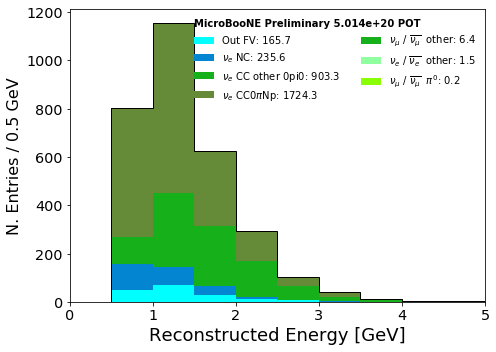

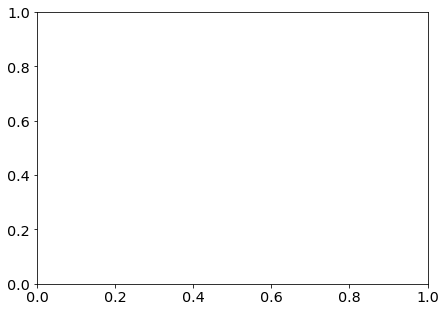

In [143]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "numu_mc": sample_set 
    }

    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21

    # NUMU
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',5,(0, 5),"Number of Protons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',5,(0, 5),"Number of Contained Showers"
    #VARIABLE, BINS, RANGE, XTIT = 'trk_llr_pid_score_v',40,(-1.0, 1.0),"LLR PID Score"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        #query="",
        currentsample = "numu_mc",
        kind="event_category",
        #kind="particle_pdg",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

n_events here =  12312

1.0
1
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5and is_signal==True& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 numu_mc
current_total  1871.1387088812219
1871.138708881221873525646515190601348876953125000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  1871.1387088812219
1871.138708881221873525646515190601348876953125000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  1871.1387088812219
187

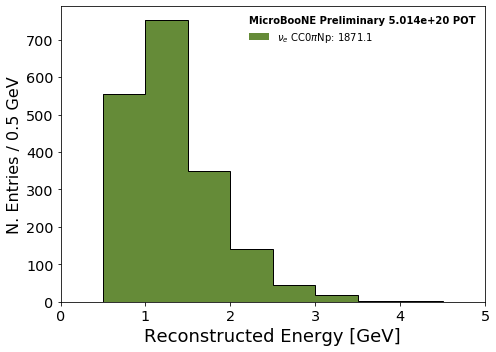

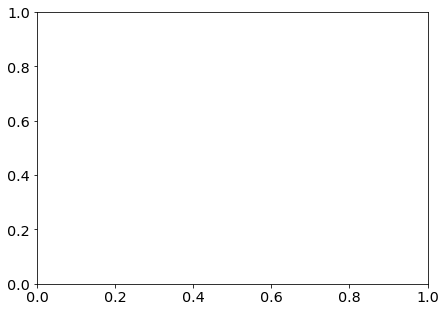

In [142]:
#THE TRUTH THAT WAS SELECTED

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21

    # NUE
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= SIGNAL_NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
No handles with labels found to put in legend.


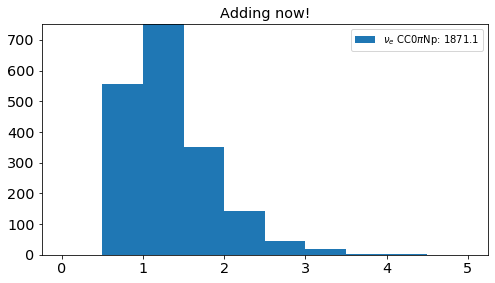

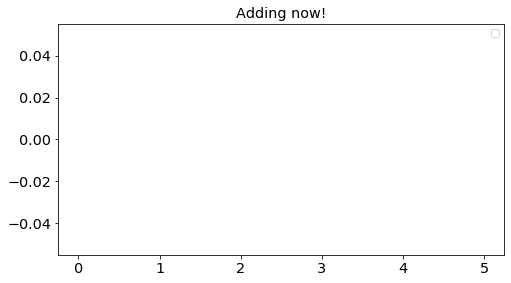

In [32]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-20, 280])    #Vtx X
    #numu_ax1.set_xlim([-140, 140])    #Vtx Y
    #numu_ax1.set_xlim([-10, 1100])    #Vtx Z
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff

    numu_stacked = numu_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [33]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

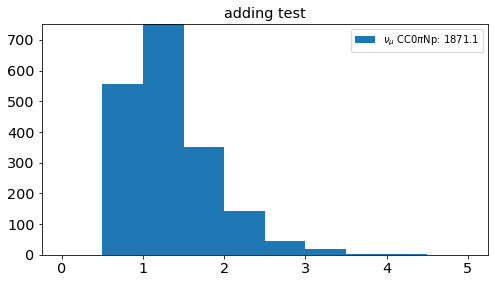

In [34]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_xlim([-20, 280])
#numu_ax1.set_xlim([-140, 140])
#numu_ax1.set_xlim([-10, 1100])
#numu_ax1.set_ylim([0, 1000])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 1000])

numu_stacked = numu_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [35]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 3  #3

numu_wanted_list = numu_stacked[0]
#numu_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, numu_stacked)

print(numu_wanted_list)

[array([6.80996797e-01, 5.55545576e+02, 7.51301233e+02, 3.50615005e+02,
       1.42106923e+02, 4.58169023e+01, 1.94413421e+01, 2.36990661e+00,
       2.94210293e+00, 3.18721434e-01]), array([6.80996797e-01, 5.55545576e+02, 7.51301233e+02, 3.50615005e+02,
       1.42106923e+02, 4.58169023e+01, 1.94413421e+01, 2.36990661e+00,
       2.94210293e+00, 3.18721434e-01])]


In [36]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

is_selected = True

if isRun3 == False:
    if (is_selected == True):
        ######full trueE
        #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection.csv')
        #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection.csv')
        vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_'+ending+'.csv')
        weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
        ########leptonMom
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')
    elif (is_selected == False):
        ######full trueE
        #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection.csv')
        #weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_recoE_usingSelection.csv')
        vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_'+ending+'.csv')
        weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
        ########leptonMom
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')
elif isRun3 == True:
    if (is_selected == True):
        ######full trueE
        #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_run3.csv')
        #weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_run3.csv')
        vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
        ########leptonMom
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    elif (is_selected == False):
        ######full trueE
        #vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_run3.csv')
        #weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_recoE_usingSelection_run3.csv')
        vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_run3_'+ending+'.csv')
        ########angleDiff
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
        ########leptonMom
        #vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
        #weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
        

n_events here =  18

1.0
1
{'numu_nue': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 numu_nue
current sample is:  numu_nue
current_total  6.198931775966063
6.198931775966062929228428401984274387359619140625000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  6.198931775966063
6.198931775966062929228428401984274387359619140625000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  6.198931775966063
6.1

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


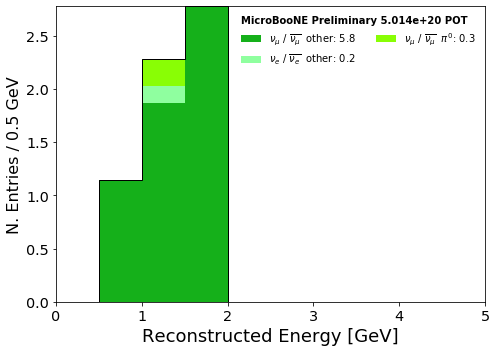

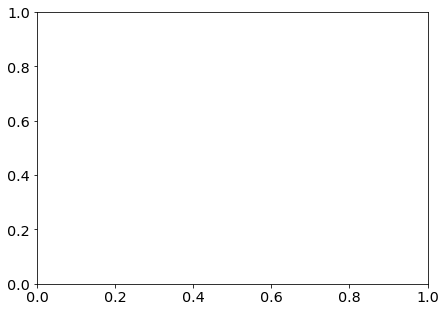

In [134]:
#The numu_nue plot (should be empty)

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []
if n_events > 0:
    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = numu_nue.iloc[start:end]

        samples = {
            #"nue_nue": nue_nue
            "numu_nue": sample_set 
        }


        scaling = 1
        if isRun3 == False:
            pot =  2e+20 
            mcratio   = pot/2.33652e+21
        elif isRun3 == True:
            pot =  5.014e20
            mcratio  = pot/1.98937e+21

        # NUE
        weights = { #full sample mc = 0.38
                    "numu_nue"  : mcratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
        #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]"
        #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"
        #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"
        #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"
        #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',5,(0, 5),"Number of Protons"
        #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',5,(0, 5),"Number of Contained Showers"
        #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
        #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"


        var, weight, label = my_plotter.plot_variable(
            VARIABLE,
            query= NUMU_SEL_QUERY,
            #query= "",
            currentsample = "numu_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss.append(var)
        weightss.append(weight)
        labss.append(label)

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
No handles with labels found to put in legend.


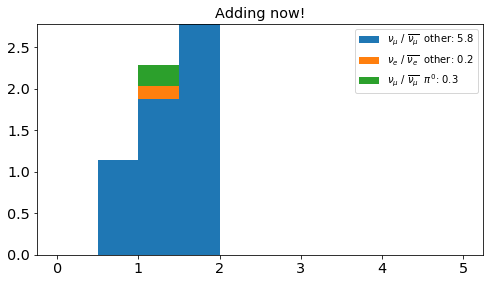

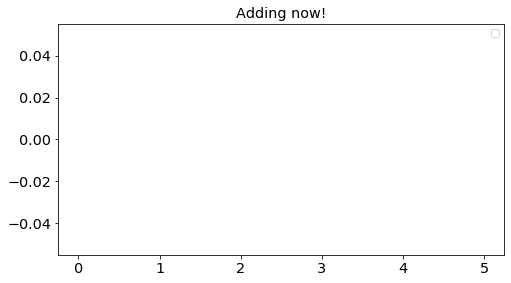

In [135]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-20, 280])    #Vtx X
    #numu_ax1.set_xlim([-140, 140])    #Vtx Y
    #numu_ax1.set_xlim([-10, 1100])    #Vtx Z
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff

    numu_stacked = numu_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [136]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

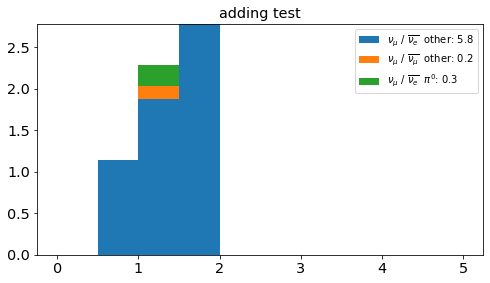

In [137]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_xlim([-20, 280])
#numu_ax1.set_xlim([-140, 140])
#numu_ax1.set_xlim([-10, 1100])
#numu_ax1.set_ylim([0, 1000])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 1000])

numu_stacked = numu_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [138]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full true
    vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    #weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    ########leptonMom
    #vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
    #weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')
elif isRun3 == True:
    ######full true
    vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    #weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    ########leptonMom
    #vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    #weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')

### Stat Errors

In [101]:
####NUMU####

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = { 
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= SIGNAL_NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  12312

1.0
1
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5and is_signal==True& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_mc

LOOK HERE FOR DETSYS
None
err numu mc: 
[1.90571865e-01 1.26666767e+02 1.73356874e+02 7.64193180e+01
 2.98562589e+01 1.06720245e+01 3.81143731e+00 9.52859327e-01
 3.81143731e-01 6.35239551e-02]
detsys numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [6.8099678e-01 5.5554553e+02 7.5130121e+02 3.5061499e+02 1.4210692e+02
 4.5816902e+01 1.9441341e+01 2.3699064e+00 2.9421029e+00 3.1872141e-01]
Returning

In [43]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

numu_mc_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_mc_stat_errs_selected = total_sels

total errs =  [0.19057186542193014, 126.6667665504429, 173.35687357881577, 76.41931803419398, 29.856258916102387, 10.672024463628087, 3.8114373084386024, 0.9528593271096506, 0.3811437308438603, 0.06352395514064338]
total selected =  [0.6809967756271362, 555.5455322265625, 751.3012084960938, 350.614990234375, 142.10691833496094, 45.81690216064453, 19.441341400146484, 2.369906425476074, 2.9421029090881348, 0.3187214136123657]


In [44]:
if isRun3 == False:
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')



    #########################
    #####angleDiff###########
    ##########################
    """
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')



    #########################
    #####angleDiff###########
    ##########################
    """
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """   

In [103]:
###NUMU NOT SIGNAL####

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NOT_SIGNAL_NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  12312

1.0
1
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5and is_signal==False& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_mc

LOOK HERE FOR DETSYS
None
err numu mc: 
[  0.12704791  64.09567074 105.89443322  75.27588684  41.3540948
  15.81746483   6.28887156   2.54095821   0.76228746   0.44466769]
detsys numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [  0.50504696 240.63681    386.09763    281.03687    155.4918
  63.44361     23.448557     9.034119     2.5064943    2.0208395 ]
Returning
{'numu_mc': 0.25203959042309876}
n

In [46]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

numu_mc_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_mc_stat_errs_selected = total_sels

total errs =  [0.12704791028128676, 64.09567073690917, 105.89443321945251, 75.27588684166241, 41.35409479655883, 15.8174648300202, 6.288871558923694, 2.540958205625735, 0.7622874616877205, 0.4446676859845036]
total selected =  [0.5050469636917114, 240.63681030273438, 386.0976257324219, 281.036865234375, 155.49180603027344, 63.44361114501953, 23.448556900024414, 9.03411865234375, 2.5064942836761475, 2.0208394527435303]


In [47]:
if isRun3 == False:    
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')



    #########################
    #####angleDiff###########
    ##########################
    """
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:    
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_run3_"+ending+".csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')



    #########################
    #####angleDiff###########
    ##########################
    """
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

In [139]:
###NUMU NUE####

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_nue.iloc[start:end]

    samples = {
        "numu_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = { #full sample mc = 0.38
                "numu_nue"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]

    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  18

1.0
1
{'numu_nue': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_nue
[0.7249573  0.89723174 1.42850447 1.21128967 1.25540247 1.52080872
 0.84784068 1.20155174 1.21451846 1.0785608  1.85851443 1.17143507
 1.00444658 1.51912964 1.02017969 1.26155205 0.73083534]

[0.7249573  0.89723174 1.42850447 1.21128967 1.25540247 1.52080872
 0.84784068 1.20155174 1.21451846 1.0785608  1.85851443 1.17143507
 1.00444658 1.51912964 1.02017969 1.26155205 0.73083534]
current_uncertainties
[ 0  4 10  3  0  0  0 

In [140]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

numu_nue_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_nue_stat_errs_selected = total_sels

total errs =  [0.0, 0.2540958205625735, 0.6352395514064337, 0.19057186542193014, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
total selected =  [0.0, 1.1413155794143677, 2.2817203998565674, 2.775895595550537, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [141]:
if isRun3 == False:    
    np.savetxt("numu_nue_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_"+ending+".csv", 
               numu_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_"+ending+".csv", 
               numu_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')



    #########################
    #####angleDiff###########
    ##########################
    """
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:    
    np.savetxt("numu_nue_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_run3_"+ending+".csv", 
               numu_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_run3_"+ending+".csv", 
               numu_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')



    #########################
    #####angleDiff###########
    ##########################
    """
    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               numu_mc_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               numu_mc_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

### Sys Errors

In [51]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  12312

1.0
1
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4    5     6     7     8     9    ...   590  \
0       597  1120  1242   538   495  804   523   855   483  1795  ...   795   
1       407   409   442   427   406  406   407   472   495   434  ...   456   
2      1448   537  1108  1263    12  464  1239  1321   710   834  ...  1566   
3       791  1013   878   744  1129  979   623  1339  1078   586  ...  1209   
4       672   896   823   67

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[   1.18604374  798.659729   1140.22705078  635.03320312  297.59863281
  109.26049805   42.88989258   11.40405273    5.44848633    2.33959961]


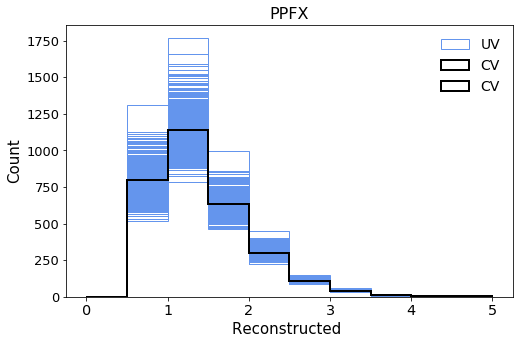

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


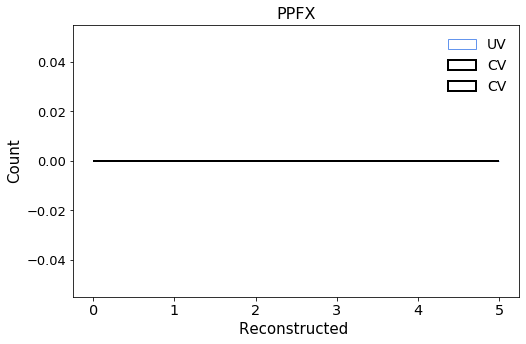

In [52]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)


    plt.show()

In [53]:
#will need to edit this if batching

numu_mc_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [54]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_ppfx.append(sum(masterlist[a]))


final_ncvs_numu_mc_ppfx = sum(n_cv_tots)


#------------------------
frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [55]:
if isRun3 == False:
    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')

    """
    ###############################
    ######angleDiff##########
    ######################

    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    ###############################
    ######leptonMom##########
    ######################

    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
if isRun3 == True:
    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')

    """
    ###############################
    ######angleDiff##########
    ######################

    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """
    ###############################
    ######leptonMom##########
    ######################

    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """

In [56]:
#############################
##### weightsPPFX ###########  NUE
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_nue.iloc[start:end]

    samples = {
        "numu_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = {
               "numu_nue"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_nue",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  18

1.0
1
{'numu_nue': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
     0     1     2     3     4     5     6     7     8     9    ...   590  \
0   1010  1018  1012   998  1034  1017  1022  1026  1025  1002  ...  1013   
1   1324   235   681   377   582  1007  1515   845   538   536  ...   723   
2    939  1685  1537  1283  1068  1533   914   826  1605   796  ...  1138   
3    827  1531   983     1  1448   532  1599   746   498   838  ...   764   
4    344   925   595   719   477    96  

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0.         1.14131558 2.28172064 2.7758956  0.         0.
 0.         0.         0.         0.        ]


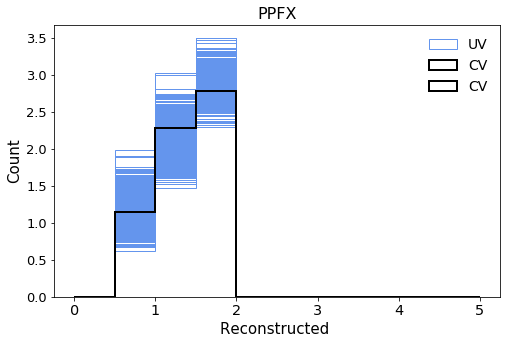

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


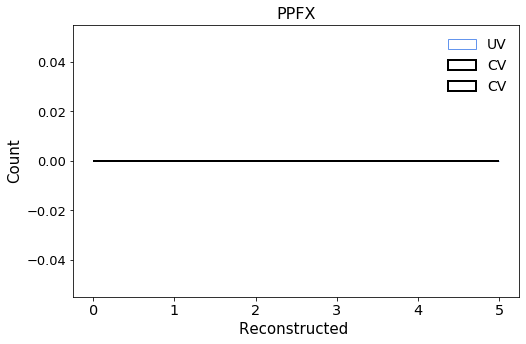

In [57]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)


    plt.show()

In [58]:
#will need to edit this if batching

numu_nue_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    numu_nue_ppfx_detvar_dict.to_csv('numu_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    numu_nue_ppfx_detvar_dict.to_csv('numu_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [59]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_nue_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_nue_ppfx.append(sum(masterlist[a]))


final_ncvs_numu_nue_ppfx = sum(n_cv_tots)


#------------------------
frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [60]:
if isRun3 == False:
    np.savetxt("numu_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_nue_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')

    """
    ###############################
    ######angleDiff##########
    ######################

    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    ###############################
    ######leptonMom##########
    ######################

    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
if isRun3 == True:
    np.savetxt("numu_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_nue_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_nue_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_nue_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')

    """
    ###############################
    ######angleDiff##########
    ######################

    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """
    ###############################
    ######leptonMom##########
    ######################

    np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_numu_mc_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_numu_mc_ppfx,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """

In [61]:
#############################
##### weightsgenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  12312

1.0
1
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   590  \
0       763   260   679   721   270  1561   426   535   765   348  ...   435   
1       534   135   108  1801     0    85  1277   116   289  1126  ...   323   
2         0     0     0     0     0     0     0     0     0     0  ...     0   
3         1     0     0     0     1     0     1     1     1     1  ...     1   
4      1346  1185  1134

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[   1.18604374  798.659729   1140.22705078  635.03320312  297.59863281
  109.26049805   42.88989258   11.40405273    5.44848633    2.33959961]


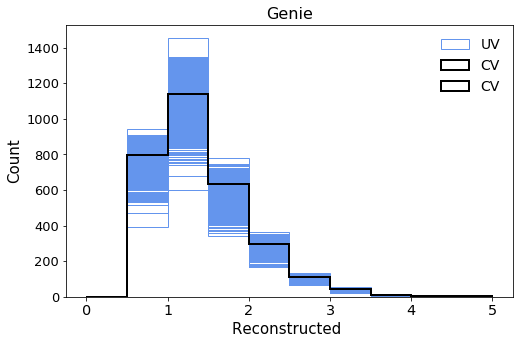

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


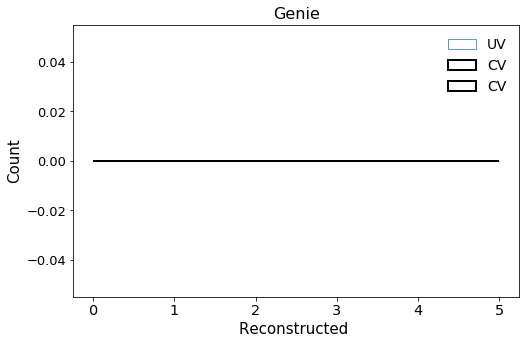

In [62]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [63]:
#will need to edit this if batching

numu_mc_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')

In [64]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_genie.append(sum(masterlist[a]))

final_ncvs_numu_mc_genie = sum(n_cv_tots)

##################################################

frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [65]:
if isRun3 == False:
    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')

    """
    ###########################
    #####angleDiff###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    ###########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
if isRun3 == True:
    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')

    """
    ###########################
    #####angleDiff###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """
    ###########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """    

In [66]:
#############################
##### weightsgenie ###########  NUE
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_nue.iloc[start:end]

    samples = {
        "numu_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = {
               "numu_nue"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_nue",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  18

1.0
1
{'numu_nue': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
     0     1     2     3     4     5     6     7     8     9    ...   590  \
0   1334  1019   832  1254  1055  1384  1115  1139  1276  1287  ...  1346   
1    484   105   189  1381   712   323  1112   217  2694   145  ...   421   
2   1116  1808  1880   878   545   839   840   770  1061  1086  ...   775   
3    846   765  1249   938  1055   814   907   358   794  1746  ...  1046   
4    699   670   255  1136   767  1194  

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0.         1.14131558 2.28172064 2.7758956  0.         0.
 0.         0.         0.         0.        ]


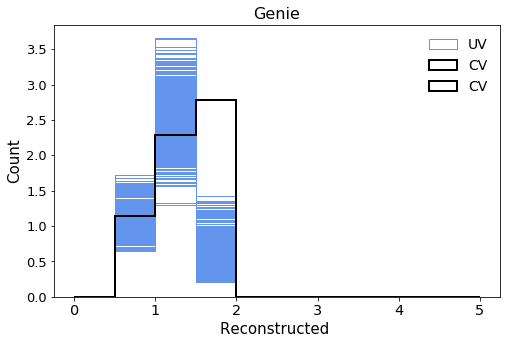

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


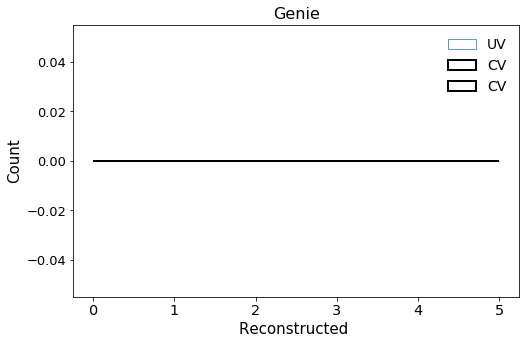

In [67]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [68]:
#will need to edit this if batching

numu_nue_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    numu_nue_genie_detvar_dict.to_csv('numu_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    numu_nue_genie_detvar_dict.to_csv('numu_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')

In [69]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_nue_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_nue_genie.append(sum(masterlist[a]))

final_ncvs_numu_nue_genie = sum(n_cv_tots)

##################################################

frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [70]:
if isRun3 == False:
    np.savetxt("numu_nue_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_nue_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_nue_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_nue_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')

    """
    ###########################
    #####angleDiff###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    ###########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
if isRun3 == True:
    np.savetxt("numu_nue_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_nue_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_nue_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_nue_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_nue_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_nue_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')

    """
    ###########################
    #####angleDiff###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """
    ###########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_numu_mc_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_numu_mc_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """    

In [71]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  12312

1.0
1
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   990  \
0       969   910  1050  1004   950   984   979   977  1041   978  ...   957   
1      1046  1048  1161   977  1157   970   787  1002   900  1092  ...   869   
2       976   928  1049  1002   965   985   973   981  1030   986  ...   958   
3       900   704  1283  1009   866   929   843   916  1122   951  ...   799   
4       980   942  1036

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[   1.18604374  798.659729   1140.22705078  635.03320312  297.59863281
  109.26049805   42.88989258   11.40405273    5.44848633    2.33959961]


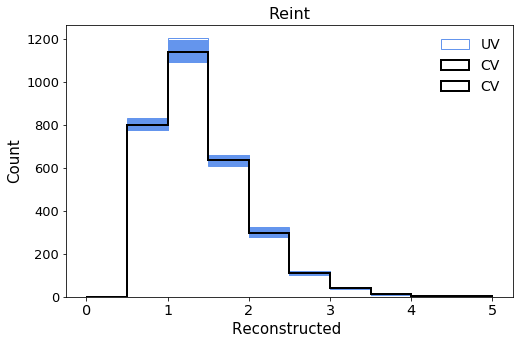

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


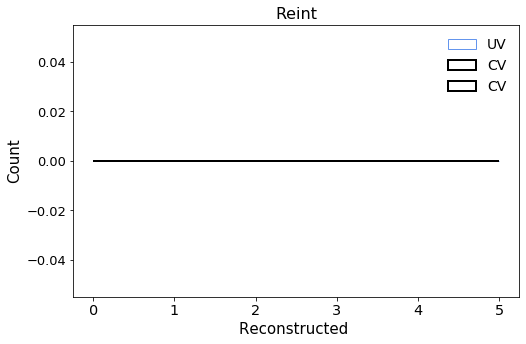

In [72]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [73]:
#will need to edit this if batching

numu_mc_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [74]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_reint.append(sum(masterlist[a]))

final_ncvs_numu_mc_reint = sum(n_cv_tots)

###################################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
    
    
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)

In [75]:
if isRun3 == False:
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')


    #############################
    #####angleDiff##########
    #######################
    """
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """

    #############################
    #####leptonMom##########
    #######################
    """
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')


    #############################
    #####angleDiff##########
    #######################
    """
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """

    #############################
    #####leptonMom##########
    #######################
    """
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """


In [76]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_nue.iloc[start:end]

    samples = {
        "numu_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = {
               "numu_nue"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_nue",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  18

1.0
1
{'numu_nue': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
     0     1     2     3     4     5     6     7     8     9    ...   990  \
0   1085  1179  1061   973  1213   996   837  1034   861  1111  ...   942   
1    941   836  1098  1009   907   970   963   957  1080   959  ...   920   
2    876   679  1199  1021   800   940   946   912  1188   907  ...   851   
3    949   856  1080  1008   916   975   973   963  1070   963  ...   934   
4   1151  1405   971   965  1337  1025  

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0.         1.14131558 2.28172064 2.7758956  0.         0.
 0.         0.         0.         0.        ]


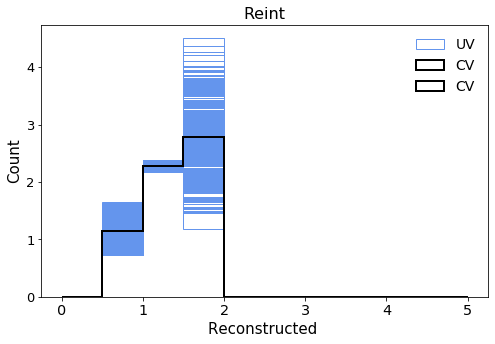

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


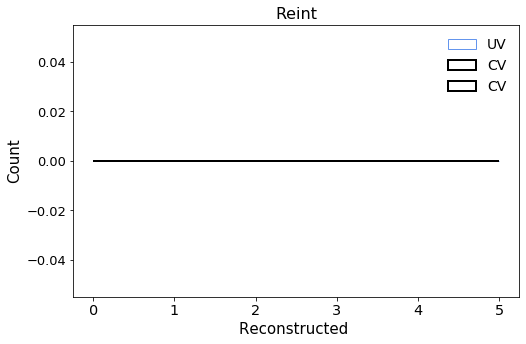

In [77]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [78]:
#will need to edit this if batching

numu_nue_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    numu_nue_reint_detvar_dict.to_csv('numu_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    numu_nue_reint_detvar_dict.to_csv('numu_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
  

In [79]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_nue_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_nue_reint.append(sum(masterlist[a]))

final_ncvs_numu_nue_reint = sum(n_cv_tots)

###################################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
    
    
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)

In [80]:
if isRun3 == False:
    np.savetxt("numu_nue_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_nue_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_nue_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_nue_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')


    #############################
    #####angleDiff##########
    #######################
    """
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """

    #############################
    #####leptonMom##########
    #######################
    """
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("numu_nue_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_nue_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_nue_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_nue_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_nue_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_nue_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')


    #############################
    #####angleDiff##########
    #######################
    """
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """

    #############################
    #####leptonMom##########
    #######################
    """
    np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_numu_mc_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_numu_mc_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """


In [81]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  12312
1.0
2
{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_mc': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contain

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[   1.18604374  798.659729   1140.22705078  635.03320312  297.59863281
  109.26049805   42.88989258   11.40405273    5.44848633    2.33959961]


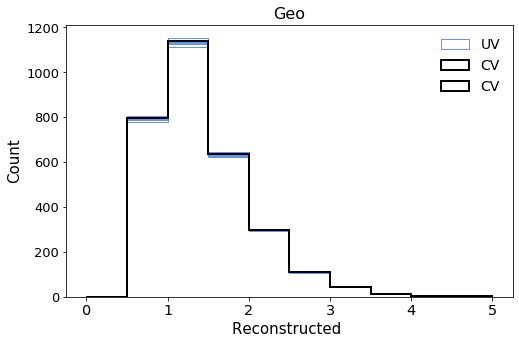

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


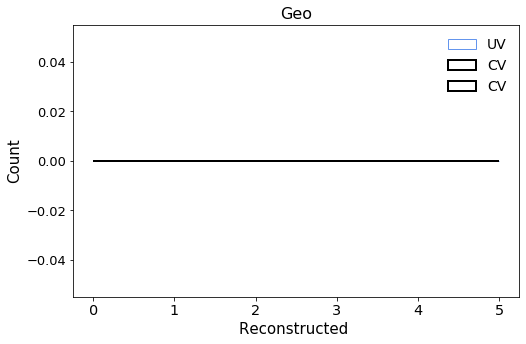

In [82]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [83]:
#will need to edit this if batching

numu_mc_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [84]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_mc_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_geo.append(sum(masterlist[a]))

final_ncvs_numu_mc_geo = sum(n_cv_tots)
    
for x in range(len(final_ns_numu_mc_geo)):
    final_ns_numu_mc_geo[x] = np.concatenate((final_ns_numu_mc_geo[x][0], final_ns_numu_mc_geo[x][1]))
    
#############################################################
frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [85]:
if isRun3 == False:
    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')

    ########################
    ####angleDiff##########
    #######################
    """

    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    ########################
    ####leptonMom##########
    #######################


    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')

    ########################
    ####angleDiff##########
    #######################
    """

    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """
    ########################
    ####leptonMom##########
    #######################


    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """


In [86]:
#############################
##### weightsNuMIGeo ###########   NUE
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_nue.iloc[start:end]

    samples = {
        "numu_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33652e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98937e+21
    
    weights = {
               "numu_nue"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_nue",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  18
1.0
2
{'numu_nue': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_nue': 0.25203959042309876}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_containe

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0.         1.14131558 2.28172064 2.7758956  0.         0.
 0.         0.         0.         0.        ]


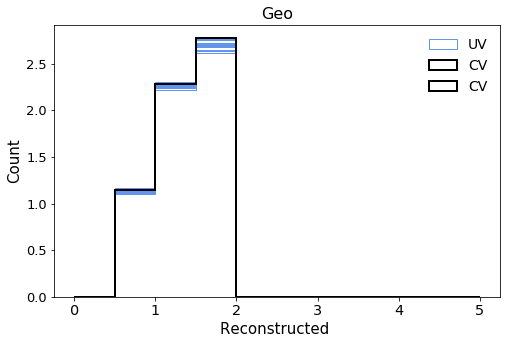

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


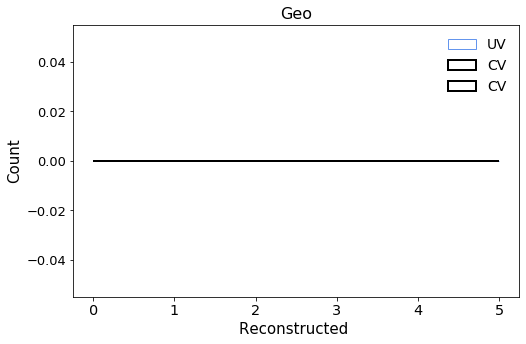

In [87]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [88]:
#will need to edit this if batching

numu_nue_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    numu_nue_geo_detvar_dict.to_csv('numu_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    numu_nue_geo_detvar_dict.to_csv('numu_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [89]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_nue_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_nue_geo.append(sum(masterlist[a]))

final_ncvs_numu_nue_geo = sum(n_cv_tots)
    
for x in range(len(final_ns_numu_mc_geo)):
    final_ns_numu_nue_geo[x] = np.concatenate((final_ns_numu_nue_geo[x][0], final_ns_numu_nue_geo[x][1]))
    
#############################################################
frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [90]:
if isRun3 == False:
    np.savetxt("numu_nue_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_nue_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_nue_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_nue_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')

    ########################
    ####angleDiff##########
    #######################
    """

    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    ########################
    ####leptonMom##########
    #######################


    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("numu_nue_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_nue_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_nue_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_nue_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_nue_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_nue_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')

    ########################
    ####angleDiff##########
    #######################
    """

    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """
    ########################
    ####leptonMom##########
    #######################


    np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_numu_mc_geo,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """


## NUMU_DIRT SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
#full sample
if isRun3 == False:
    DRT  = '/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND
elif isRun3 == True:
    DRT  = '/neutrinoselection_filt_run3b_dirt_overlay'  +ls.APPEND

#actually fetch datasets
numu_dirt  = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_dirt]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", "trk_pfp_id",
        "category", "ccnc", "swtrig_pre",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
        "reco_e", "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score", "proton_e", "elec_e",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['trk_sce_end_z_v', 'nu_pdg', 'trk_range_muon_mom_v', 'reco_nu_vtx_y', 'trk_sce_end_y_v', 'ccnc', 'interaction', 'mc_pdg', 'slnunhits', 'CosmicDirAll3D', 'reco_e', 'pion_e', 'true_e_visible', 'reco_nu_vtx_sce_x', 'slnhits', 'run', 'trk_llr_pid_score_v', 'trk_sce_end_x_v', 'isVtxInFiducial', 'reco_nu_vtx_sce_z', 'trk_theta', 'shr_tkfit_dedx_Y', 'backtracked_pdg', 'n_showers_contained', 'muon_e', 'nmuon', 'topological_score', 'nproton', 'sub', 'trk_energy_muon', 'evt', 'npi0', '_opfilter_pe_beam', '_opfilter_pe_veto', 'CosmicIP', 'proton_e', 'trk_phi', 'npion', 'trk_mcs_muon_mom_v', 'CosmicIPAll3D', 'flash_pe', 'swtrig_pre', 'nslice', 'pi0truth_elec_etot', 'slpdg', 'pi0_e', 'evnunhits', 'reco_nu_vtx_sce_y', 'category', 'slclustfrac', 'reco_nu_vtx_z', 'reco_nu_vtx_x', 'trk_energy_tot', 'trk_sce_start_x_v', 'elec_e', 'tksh_distance', 'shr_energy_tot_cali']


In [6]:
import time
s = time.time()

import pandas as pandas

dirt_var = numu_variables + numu_varMC + WEIGHTS + SYSTEMATICS + PPFX

# This needs modifications (add variables from above)
uproot_v = [numu_dirt] 
var_v    = [dirt_var] 



for ii, CV in enumerate(uproot_v):
    print("1")
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    print()
    print("2")
    load_data_run123.process_uproot_numu(CV,CVDF)
    print("3")
    if ii == 0:
        print("4")
        numu_dirt =  CVDF

s2 = time.time()

print("runtime = ", s2-s)
#Approx 5 mins

1

2
trk_llr_pid_v  [[] [] [0.9629669 0.92838156 0.5586327] ... [] [] []]
trk_score_v  [[] [] [0.9999977 0.99987674 0.92631394] ... [] [] []]
Here:
trk_range_muon_mom_v  [[] [] [0.45959798 0.26267546 0.12103449] ... [] [] []]
trk_mcs_muon_mom_v  [[] [] [0.79999506 0.44799778 1.8220291] ... [] [] []]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


3
4
runtime =  92.57980179786682


In [7]:
df_v = [numu_dirt]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [8]:
df_v = [numu_dirt]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [9]:
numu_dirt.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 \
and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0", inplace=True)

In [10]:
s = time.time()

df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    
    
s2 = time.time()
print("runtime = ", s2-s)
#Run1 = 
#Run3 = 

runtime =  0.15024566650390625


In [11]:
if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    dirt_pot =  1.42143e+21
    scalingDRT = 0.35
elif isRun3 == True:
    beamon_pot = 5.014E20
    dirt_pot =  1.03226e+21
    scalingDRT = 0.45    

numu_dirt['pot_scale'] = (beamon_pot/dirt_pot)*scalingDRT

In [12]:
numu_dirt['totweight_data'] = numu_dirt['pot_scale']*numu_dirt['weightSplineTimesTuneTimesPPFX']

In [13]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [14]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [15]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

runtime =  3.71026873588562


In [14]:
#numu_dirt["is_signal"]   = numu_dirt["category"] == 2
#print(numu_mc["is_signal"])

In [16]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [17]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [17]:
df_v = [numu_dirt]
    
#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
for i,df in enumerate(df_v):
    print(df["n_muons_tot"])

entry
0         0
1         0
2         0
3         0
4         0
         ..
389259    0
389260    0
389261    0
389262    0
389263    0
Name: n_muons_tot, Length: 389264, dtype: int64


In [16]:
#numu_dirt.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and n_showers_contained==0", inplace=True)

In [17]:
df_v = [numu_dirt]
    
#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_range_muon_mom_v"].copy()
    for j, row in df.iterrows():
        if (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])

entry
1138      0.241054
1205      0.472777
3527      0.317174
4255      0.392615
5356      0.921958
            ...   
566111    0.549741
566137    0.222463
566221    0.395383
567666     1.10804
569370       1.053
Name: muon_mom, Length: 408, dtype: object


In [18]:
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    #df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    #df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    #df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    #df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])
    print(df['cosNu_Angle_Numi_Muon'])
    print(df['reco_nu_vtx_sce_x'])

entry
1138     -0.766328
1205      0.794024
3527      0.341467
4255     -0.800791
5356      0.974622
            ...   
566111    0.735774
566137    0.637509
566221   -0.866412
567666   -0.386616
569370    0.974186
Name: cosNu_Angle_Numi_Muon, Length: 408, dtype: float64
entry
1138       13.671485
1205      112.259079
3527      226.951233
4255      110.254593
5356        6.271605
             ...    
566111    108.329697
566137     82.859444
566221     98.982269
567666     20.502098
569370      5.779076
Name: reco_nu_vtx_sce_x, Length: 408, dtype: float32


In [18]:
numu_dirt   = numu_dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

In [19]:
df_v = [numu_dirt]
for i,df in enumerate(df_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
                                     & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                     & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                     & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                     & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1

In [20]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where( (df.swtrig_pre==1)&(df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["nue_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_CC_Npi0']== True), 'category' ] = 3
    df["nue_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['nue_CC_0pi0']== True), 'category' ] = 4
    
    df["nue_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 5
    df["nue_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 6
    
    df["numubar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['numubar_1eNp']== True), 'category' ] = 7
    df["numu_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1), True, False)
    df.loc[ (df['numu_NC']== True), 'category' ] = 8
    df["numu_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['numu_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["numu_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False) , True, False)
    df.loc[ (df['numu_other']== True), 'category' ] = 10
    df["nue_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==12)) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_Npi0']== True), 'category' ] = 11
    df["nue_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==12)) &  (df.npi0==0), True, False)
    df.loc[ (df['nue_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.nue_CC_Npi0==False)
                             & (df.nue_CC_0pi0==False) & (df.nue_NC_Npi0==False) & (df.nue_NC_0pi0==False)
                             & (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False)
                             & (df.numu_other==False) & (df.nue_Npi0==False) & (df.nue_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

Set up complete.

In [21]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_dirt"  : numu_dirt
}

scaling = 1
SPLIT = 1.0

if isRun3 == False:
    pot       =  2e+20
    dirtratio = pot/1.42143e+21
    scalingDRT = 0.65 #0.35
elif isRun3 == True:
    pot       =  5.014e+20
    dirtratio = pot/1.03226e+21
    scalingDRT = 0.45   

weights = {  "numu_dirt": dirtratio* SPLIT * scalingDRT,  
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'numu_dirt': 0.21857865266502624}


In [22]:
#NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
#and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
#and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 \
#and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 \
#and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 \
#and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 \
#and n_showers_contained == 0"
#NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#NUMU_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'

NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 \
and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0"
NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
NUMU_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

n_events here =  208

1.0
1
{'numu_dirt': 0.21857865266502624}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 numu_dirt
current sample is:  numu_dirt
TEST
1
2
3
current_total  38.997186579719724
38.997186579719723908965534064918756484985351562500000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  38.997186579719724
38.997186579719723908965534064918756484985351562500000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  

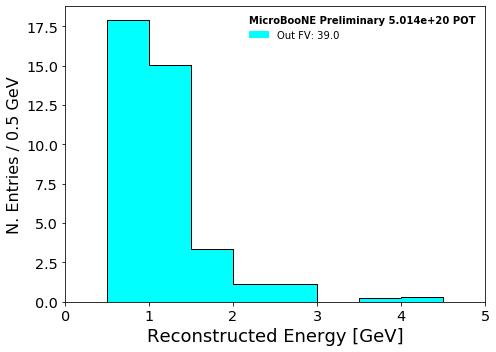

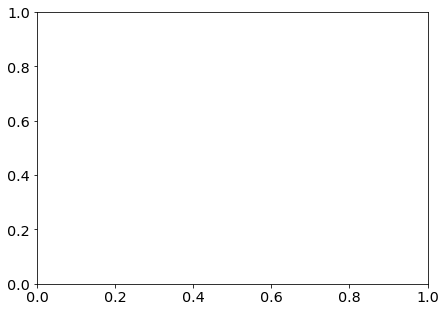

In [23]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45

    # NUE
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',5,(0, 5),"Number of Protons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',5,(0, 5),"Number of Contained Showers"
    #VARIABLE, BINS, RANGE, XTIT = 'trk_llr_pid_score_v',40,(-1.0, 1.0),"LLR PID Score"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        #query= "",
        currentsample = "numu_dirt",
        kind="event_category",
        #kind="psrticle_pdg",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


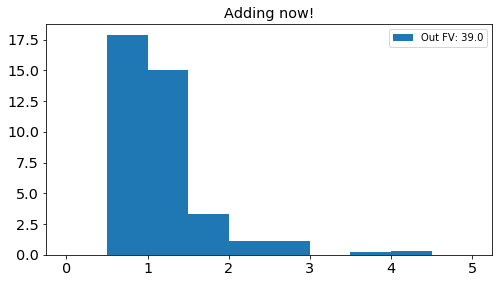

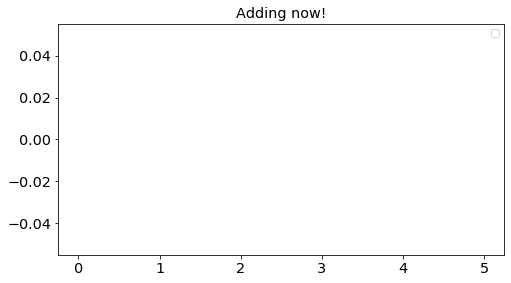

In [24]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff
    
    #print(varss)

    numu_stacked = numu_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [25]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

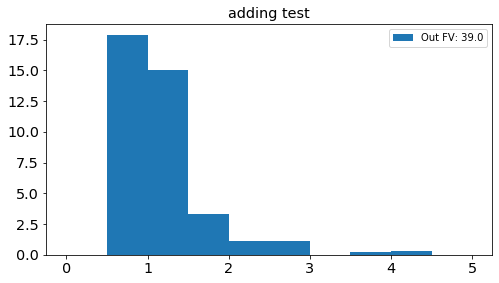

In [26]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_ylim([0, 30])

##AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 15])

numu_stacked = numu_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [27]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

numu_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, numu_stacked)

print(numu_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [28]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full true
    vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    #weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    ########leptonMom
    #vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
    #weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')
elif isRun3 == True:
    ######full true
    vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    #weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    ########leptonMom
    #vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    #weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')


### Stat Err

In [29]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  208

1.0
1
{'numu_dirt': 0.21857865266502624}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_dirt

LOOK HERE FOR DETSYS
None
err numu dirt: 
[0.         3.58324706 3.39214055 0.81220267 0.28665976 0.23888314
 0.         0.04777663 0.04777663 0.        ]
detsys numu dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [ 0.         17.8701     15.025186    3.3312564   1.1273626   1.1328404
  0.          0.22813681  0.2823049   0.        ]
Returning
{'numu_dirt': 0.21857865266502624}
nslice == 1 and ( (_opfilter_pe_beam 

In [30]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

numu_dirt_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_dirt_stat_errs_selected = total_sels

total errs =  [0.0, 3.583247055064364, 3.392140545460931, 0.8122026658145891, 0.2866597644051491, 0.2388831370042909, 0.0, 0.04777662740085818, 0.04777662740085818, 0.0]
total selected =  [0.0, 17.870100021362305, 15.025185585021973, 3.33125638961792, 1.127362608909607, 1.1328403949737549, 0.0, 0.22813680768013, 0.28230491280555725, 0.0]


In [31]:

if isRun3 == False:
    np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               numu_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               numu_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')


    #########################
    #####angleDiff###########
    ##########################
    """
    np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
               numu_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
               numu_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
               numu_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
               numu_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:
    np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               numu_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               numu_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')


    #########################
    #####angleDiff###########
    ##########################
    """
    np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               numu_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               numu_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("numu_dirt_stat_errs_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               numu_dirt_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               numu_dirt_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

### Sys Errs

In [32]:
############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  208
n_events/2 here =  104.0

1.0
1
{'numu_dirt': 0.21857865266502624}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
      0     1     2     3     4     5     6     7     8     9    ...   590  \
0    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
1    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
2    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
3    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
4    1

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 0.         17.87010002 15.02518654  3.33125687  1.1273613   1.1328392
  0.          0.22813797  0.28230667  0.        ]


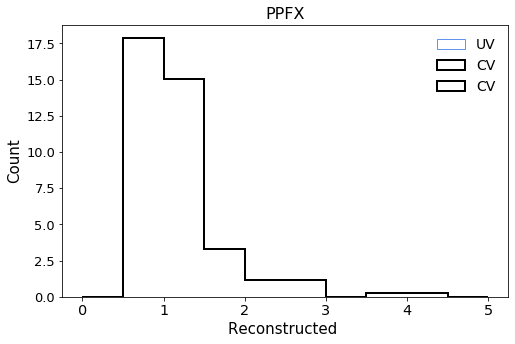

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


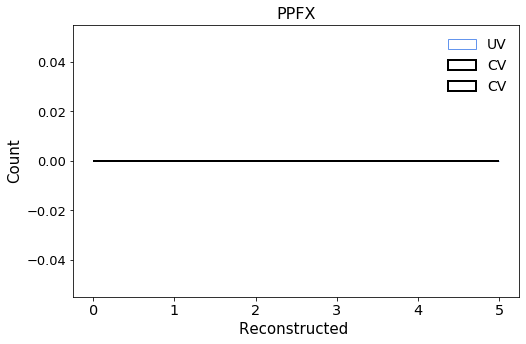

In [33]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)



    plt.show()

In [34]:
#will need to edit this if batching

numu_dirt_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [35]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_ppfx.append(sum(masterlist[a]))

final_ncvs_numu_dirt_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [36]:
if isRun3 == False:
    np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')


    """
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """ 
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')


    """
    #################################
    #####angleDiff##################
    ############################

    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """ 
    #################################
    #####leptonMom##################
    ############################

    np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_nue_dirt_ppfx[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_ppfx,
               delimiter =", ", 
               fmt ='% s')

    #np.savetxt("nue_nue_syserss_df_ppfx.csv", 
    #           df_nue_nue_ppfx,
    #           delimiter =", ", 
    #           fmt ='% s')

    ###########################################

    total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """

In [37]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse = 500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  208
n_events/2 here =  104.0

1.0
1
{'numu_dirt': 0.21857865266502624}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
      0     1     2     3     4     5     6     7     8     9    ...   590  \
0    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
1    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
2    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
3    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
4    1

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 0.         17.87010002 15.02518654  3.33125687  1.1273613   1.1328392
  0.          0.22813797  0.28230667  0.        ]


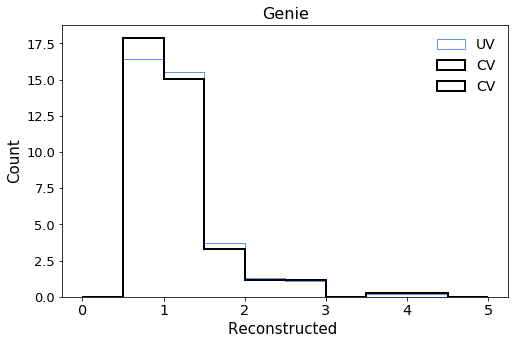

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


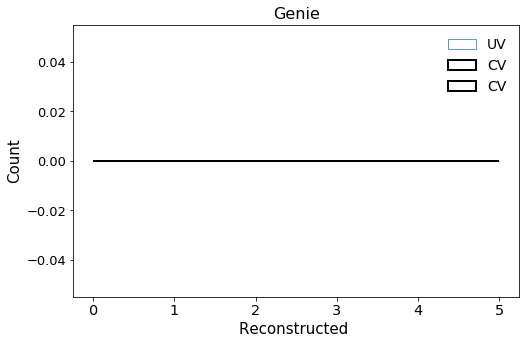

In [38]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    plt.show()

In [39]:
#will need to edit this if batching

numu_dirt_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [40]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_genie.append(sum(masterlist[a]))

final_ncvs_numu_dirt_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
print(total_genie_df_splines)


      0     1     2     3     4     5     6     7     8     9    ...   590  \
0    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
1    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
2    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
3    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
4    1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
171  1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
172  1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
173  1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
174  1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
175  1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   

      591   592   593   594   595   596   597   598   599  
0  

In [41]:
if isRun3 == False:
    np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    """
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    """
    #####################
    ###AngleDiff###
    ######################
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """
    #####################
    ###leptonMom###
    ######################
    np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_nue_dirt_genie[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_genie,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """


In [42]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  208
n_events/2 here =  104.0
weightsReint
1.0
1
{'numu_dirt': 0.21857865266502624}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 0.         17.87010002 15.02518654  3.33125687  1.1273613   1.1328392
  0.          0.22813797  0.28230667  0.        ]


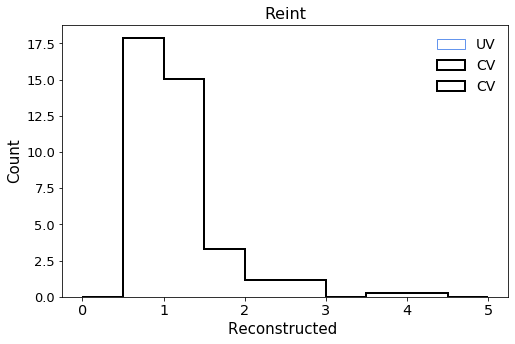

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


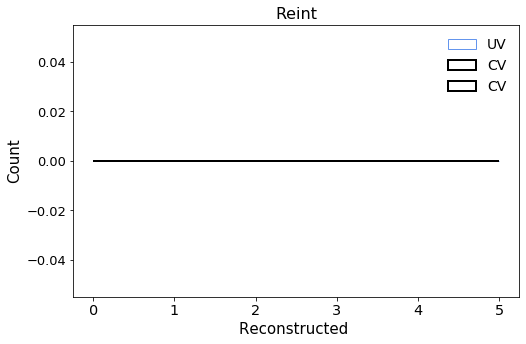

In [43]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [44]:
#will need to edit this if batching

numu_dirt_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [45]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_reint.append(sum(masterlist[a]))

final_ncvs_numu_dirt_reint = sum(n_cv_tots)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)


In [46]:
if isRun3 == False:
    np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')


    """
    #################
    ###angleDiff#####
    #################

    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')


    """
    #################
    ###angleDiff#####
    #################

    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """
    #################
    ###leptonMom#####
    #################

    np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_nue_dirt_reint[0],
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_reint,
               delimiter =", ", 
               fmt ='% s')

    ###########################################

    total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """


In [47]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        dirtratio = pot/1.42143e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
    
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  208
n_events/2 here =  104.0
1.0
2
{'numu_dirt': 0.21857865266502624}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0 and reco_e > 0.04 and reco_e < 5 and true_e > 0.04 and true_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_dirt': 0.21857865266502624}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 0.         17.87010002 15.02518654  3.33125687  1.1273613   1.1328392
  0.          0.22813797  0.28230667  0.        ]


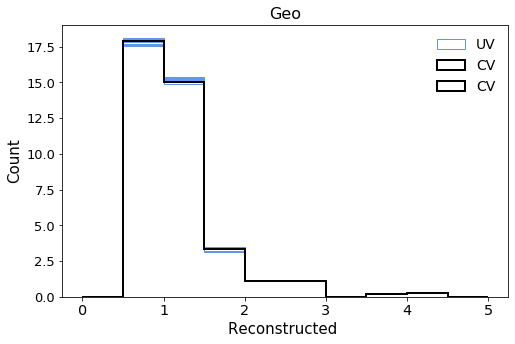

[0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75 4.25 4.75]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


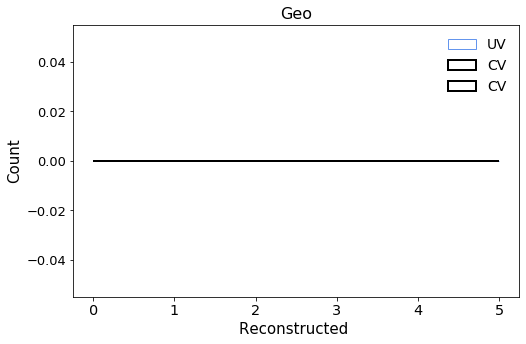

In [48]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    bin_centers = np.arange(0.25, 5.25, 0.5)
    bins = np.arange(0, 5.5, 0.5)
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    plt.show()

In [49]:
#will need to edit this if batching

numu_dirt_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [50]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_geo.append(sum(masterlist[a]))

final_ncvs_numu_dirt_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_numu_dirt_geo)):
    final_ns_numu_dirt_geo[x] = np.concatenate((final_ns_numu_dirt_geo[x][0], final_ns_numu_dirt_geo[x][1]))
    
    
print(final_ns_numu_dirt_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
print(total_geo_df_splines)

[ 0.         17.93908359 15.28655174  3.44840651  1.13131786  1.13494769
  0.          0.22875046  0.2781227   0.          0.         18.03308857
 15.27046196  3.31760105  1.1409991   1.13271034  0.          0.23738546
  0.28246638  0.        ]
entry
7650      0.224330
8478      0.114870
8927      0.238394
9613      0.255724
16066     0.275238
            ...   
380638    0.233486
385804    0.230127
385999    0.224515
386437    0.202241
387374    0.316221
Name: weightSplineTimesTuneTimesPPFX, Length: 176, dtype: float32


In [51]:
if isRun3 == False:
    np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ns_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
               final_ncvs_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')

    """
    #####################
    ###angleDiff########
    ####################

    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDif_usingSelectionf.csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection.csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_angleDif_usingSelectionf.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection.csv')
    """
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection.csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection.csv')
    """
elif isRun3 == True:
    np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ns_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
               final_ncvs_numu_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')

    """
    #####################
    ###angleDiff########
    ####################

    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDif_usingSelection_run3.csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_angleDif_usingSelection_run3.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    """
    """
    #####################
    ###leptonMom########
    ####################

    np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ns_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               final_ncvs_nue_dirt_geo,
               delimiter =", ", 
               fmt ='% s')

    #######################################################

    total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    """


## NUMU_EXT

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
#full sample
if isRun3 == False:
    EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
elif isRun3 == True:
    EXT  = '/neutrinoselection_filt_run3b_beamoff'         +ls.APPEND

#actually fetch datasets
numu_ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_ext]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc", "swtrig_pre", 
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "shr_energy_tot_cali", "proton_e", "elec_e",
        "reco_e","trk_energy_tot","n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['trk_energy_muon', 'nmuon', 'slnhits', 'isVtxInFiducial', 'pion_e', 'trk_sce_end_x_v', 'npion', 'trk_sce_end_y_v', '_opfilter_pe_veto', 'run', 'shr_tkfit_dedx_Y', 'elec_e', 'trk_llr_pid_score_v', 'swtrig_pre', 'CosmicIPAll3D', 'muon_e', 'nslice', 'slclustfrac', 'topological_score', 'sub', 'category', 'evt', 'nu_pdg', 'tksh_distance', 'shr_energy_tot_cali', 'reco_nu_vtx_sce_z', 'slnunhits', 'slpdg', 'CosmicIP', 'trk_energy_tot', 'trk_theta', 'mc_pdg', 'reco_nu_vtx_y', 'reco_e', 'trk_range_muon_mom_v', 'trk_sce_end_z_v', '_opfilter_pe_beam', 'CosmicDirAll3D', 'pi0truth_elec_etot', 'trk_phi', 'backtracked_pdg', 'nproton', 'proton_e', 'true_e_visible', 'interaction', 'npi0', 'reco_nu_vtx_sce_y', 'pi0_e', 'trk_mcs_muon_mom_v', 'reco_nu_vtx_z', 'ccnc', 'reco_nu_vtx_sce_x', 'n_showers_contained', 'reco_nu_vtx_x', 'evnunhits', 'flash_pe', 'trk_sce_start_x_v']


In [6]:
import time
s = time.time()

import pandas as pandas

ext_var  = numu_variables + numu_varMC  ##added second part

# This needs modifications (add variables from above)
uproot_v = [numu_ext] 
var_v    = [ext_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_ext = CVDF

s2 = time.time()
print(s2 - s)
#Approx 3 mins

trk_llr_pid_v  [[] [] [] ... [0.97052354 0.46686205] [] [0.9231277]]
trk_score_v  [[] [] [] ... [1.0 0.010001138] [] [0.9994478]]
Here:
trk_range_muon_mom_v  [[] [] [] ... [0.5356459 0.08237955] [] [0.41866612]]
trk_mcs_muon_mom_v  [[] [] [] ... [0.4799978 14.999432] [] [0.8129949]]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


579.645393371582


In [7]:
if isRun3 == False:
    # The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
    extratio  = 5268051/9199232.74
    # We scale down the EXT to account for neutrino occupancy
    scalingEXT = 0.98
elif isRun3 == True:
    extratio  = 10363728.0/32878305.25
    scalingEXT = 0.98

numu_ext['pot_scale'] = extratio * scalingEXT

In [8]:
numu_ext['totweight_data'] = numu_ext['pot_scale']

In [9]:
df_v = [numu_ext]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [10]:
df_v = [numu_ext]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    #df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

numu_ext["extdata"] = np.ones_like(numu_ext["isVtxInFiducial"])

In [11]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_6587/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  75.02053022384644


In [12]:
#numu_ext["is_signal"]   = numu_ext["category"] == 2

In [12]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [13]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [17]:
#numu_ext.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and n_showers_contained == 0", inplace=True)

NameError: name 'numu_dirt' is not defined

In [72]:
df_v = [numu_ext]
    
#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
#for i,df in enumerate(df_v):
#    df["muon_mom"] = df["trk_range_muon_mom_v"].copy()
for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_range_muon_mom_v"].copy()
    for j, row in df.iterrows():
        if (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])

entry
7032      0.192857
9575      0.253589
12294     0.228936
13650     0.208716
14191     0.149407
            ...   
894137    0.266947
895153       0.167
897852     0.71253
898897    0.297465
902190    0.623877
Name: muon_mom, Length: 566, dtype: object


In [73]:
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    #df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    #df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    #df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    #df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

In [14]:
df_v = [numu_ext]
for i,df in enumerate(df_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
                                     & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                     & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                     & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                     & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1

Set up complete.

In [15]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_ext"  : numu_ext
}

SPLIT = 1.0
scaling = 1
scalingEXT = 0.98

if isRun3 == False:
    pot =  2e+20
    extratio  = 5268051/9199232.74 
elif isRun3 == True:
    pot =  5.014e+20
    extratio  = 10363728.0/32878305.25


weights = {   "ext" : extratio * SPLIT * scalingEXT, 
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'ext': 0.3089104916683624}


In [16]:
"""
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 \
and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 \
and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 \
and n_showers_contained == 0"
NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#No true query as data
"""
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 \
and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0"
NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += 'and is_signal==False'

In [17]:
test = np.nansum(numu_ext.query(SIGNAL_NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(numu_ext.query(NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 0.0
total signal events = 477.26670962762


n_events here =  3211097

1.0
1
{'ext': 0.3089104916683624}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 numu_ext
current_plotted_variable  [0.83381882 0.84914865 2.07219573 ... 1.05243123 0.81020714 1.78556051]
1
2
3
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
total after ext 477.2667096276199
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE---------------------

No handles with labels found to put in legend.


Returning
{'ext': 0.3089104916683624}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 numu_ext
current_plotted_variable  []
1
2
3
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
total after ext 0.0
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  0.0
0.00000000000000000000000000000000000000000000000000000000000000000000000

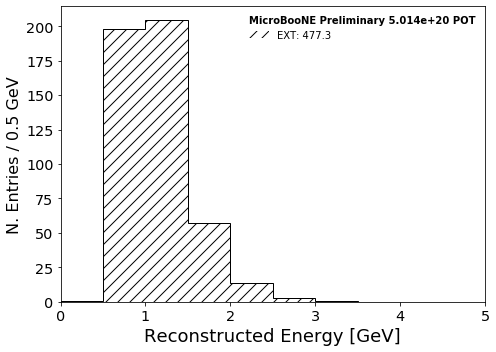

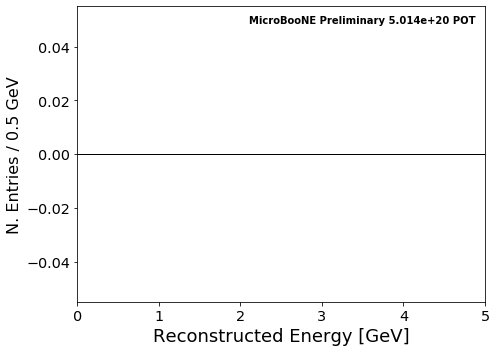

In [18]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_ext.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_ext.iloc[start:end]

    samples = {
        "numu_ext": sample_set 
    }


    if isRun3 == False:
        pot =  2e+20
        extratio  = 5268051/9199232.74 
        scalingEXT = 0.98
    elif isRun3 == True:
        pot =  5.014e+20
        extratio  = 10363728.0/32878305.25
        scalingEXT = 0.98
    
    # NUE
    weights = { "ext" : extratio * SPLIT * scalingEXT,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',5,(0, 5),"Number of Protons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',5,(0, 5),"Number of Contained Showers"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        #query= "",
        currentsample = "numu_ext",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


[array([0.83381882, 0.84914865, 2.07219573, ..., 1.05243123, 0.81020714,
       1.78556051]), array([], dtype=float64)]
[array([0.83381882, 0.84914865, 2.07219573, ..., 1.05243123, 0.81020714,
       1.78556051]), array([], dtype=float64)]


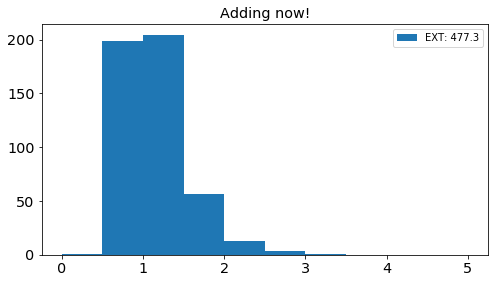

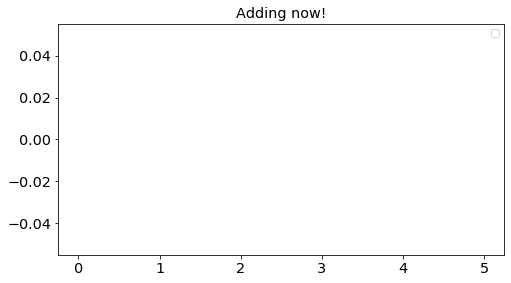

In [19]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff
    
    print(varss)

    numu_stacked = numu_ax1.hist(
                varss[i],
                weights=list(weightss[i]),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [20]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = np.concatenate(varss)
weightss_tot = np.concatenate(weightss)

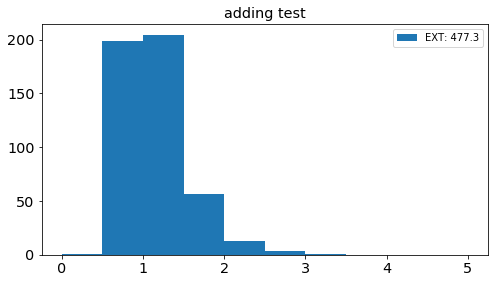

In [21]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = labss


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_ylim([0, 300])

#AngleDiff
#numu_ax1.set_xlim([-1, 1])
#numu_ax1.set_ylim([0, 80])

numu_stacked = numu_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [22]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

numu_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, numu_stacked)

print(numu_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [23]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    ######full trueE
    vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    #weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    ########leptonMom
    #vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
    #weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')
elif isRun3 == True:
    ######full trueE
    vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    #weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    ########leptonMom
    #vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    #weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')


### Stat Errors

In [24]:
"""
#This is the stat errors on the selected ext

import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_ext.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/5))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_ext.iloc[start:end]

    samples = {
        "numu_ext": sample_set 
    }

    
    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    # The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
    extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
    # We scale down the EXT to account for neutrino occupancy
    scalingEXT = 0.98
    

    
    weights = { #full sample mc = 0.38  
                "numu_ext" : extratio * SPLIT * scalingEXT, #set0 
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reco Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        #query= truthsel_nue,
        currentsample = "numu_ext",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
"""

'\n#This is the stat errors on the selected ext\n\nimport staterr_batch_plotter_alex\nimport importlib\nimportlib.reload(staterr_batch_plotter_alex)\nscaling = 1\n\nSPLIT = 1.0\n\nn_events = numu_ext.shape[0]\nprint("n_events here = ", n_events)\nprint("n_events/2 here = ", np.floor(n_events/5))\nprint("")\nbatch_size = n_events\n#batch_size = int(np.floor(n_events/5))\n#n_events = batch_size\n\nerrs = []\ndetsyss = []\nsels = []\n\nprint(n_events/batch_size)\nprint(int(n_events/batch_size))\n\nfor i in range(int(n_events/batch_size)+1):\n#for i in range(1):\n    start = i*batch_size\n    if (start + batch_size) < n_events:\n        end = start + batch_size\n    else:\n        end = n_events\n    sample_set = numu_ext.iloc[start:end]\n\n    samples = {\n        "numu_ext": sample_set \n    }\n\n    \n    scaling = 1\n    # This is the data POT we normalize to (comes from the data Ntuples)\n    pot =  2e+20 #partial file: 8.885e+19\n    # The EXT sample (off beam) is scaled using the tr

In [25]:
"""
#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)
print("")

numu_ext_stat_errs = total_errs
"""

'\n#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...\nmasterlist = []\ntemplist = []\nfor i in range((len(errs[0]))):\n    masterlist.append(templist)\n    templist = []\n    for j in range(len(errs)):\n        templist.append(errs[j][i])\nmasterlist.append(templist)\n    \nmasterlist.pop(0)\n\n\n#deal with adding the errors in each bin\ntotal_errs = []\nholdlist = []\nfor f in masterlist:\n    total_errs.append(sum(holdlist))\n    #print("------------------------------")\n    holdlist = []\n    for g in f:\n        #just add them as they differnt parts of the same total number. This then matches previous when doing total\n        holdlist.append(g)\ntotal_errs.append(sum(holdlist))\n\ntotal_errs.pop(0)\nprint("total errs = ", total_errs)\nprint("")\n\nnumu_ext_stat_errs = total_errs\n'

[ 0.96266893 14.08263241 14.28950087  7.53919959  3.64460576  1.75758497
  0.78601589  0.          0.          0.        ]


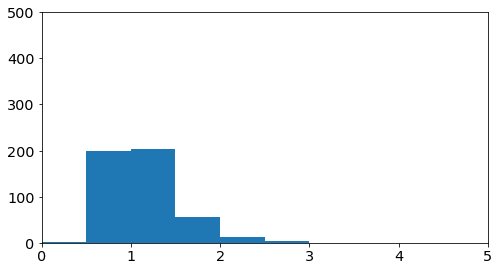

In [26]:
#A poisson uncertainty is assumed for beam off (see krishan's thesis p.182)

numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
numu_ax1.set_xlim([0, 5])
numu_ax1.set_ylim([0, 500])


numu_stacked = numu_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)


numu_ext_stat_errs = np.sqrt(numu_stacked[0])

print(numu_ext_stat_errs)

In [27]:
if isRun3 == False:
    np.savetxt("numu_ext_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_"+ending+".csv", 
               numu_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')
    """
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """
elif isRun3 == True:
    np.savetxt("numu_ext_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_"+ending+".csv", 
               numu_ext_stat_errs,
               delimiter =", ", 
               fmt ='% s')
    """
    #########################
    #####angleDiff###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff_usingSelection_run3.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')

    """
    """
    #########################
    #####leptonMom###########
    ##########################

    np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               nue_nue_stat_errs,
               delimiter =", ", 
               fmt ='% s')

    np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom_usingSelection_run3.csv", 
               nue_nue_stat_errs_selected,
               delimiter =", ", 
               fmt ='% s')
    """

## NUMU_DATA SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
#full sample
if isRun3 == False:
    BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
elif isRun3 == True:
    BNB  = '/neutrinoselection_filt_run3b_beamon_beamgood' +ls.APPEND

#actually fetch datasets
numu_data  = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_data]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc", "swtrig_pre",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "shr_energy_tot_cali", "proton_e", "elec_e",
        "reco_e","trk_energy_tot","n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['trk_sce_end_x_v', 'nu_pdg', 'nmuon', 'shr_energy_tot_cali', 'isVtxInFiducial', 'proton_e', 'flash_pe', 'pi0truth_elec_etot', 'evnunhits', 'CosmicDirAll3D', 'CosmicIPAll3D', 'topological_score', 'reco_nu_vtx_sce_y', 'npion', 'pion_e', 'category', 'trk_range_muon_mom_v', 'trk_llr_pid_score_v', 'mc_pdg', 'reco_nu_vtx_y', 'sub', 'ccnc', 'reco_nu_vtx_x', '_opfilter_pe_beam', 'slnhits', 'npi0', 'run', 'backtracked_pdg', 'reco_e', 'reco_nu_vtx_sce_z', 'true_e_visible', 'trk_theta', 'CosmicIP', 'nproton', 'trk_sce_end_y_v', 'reco_nu_vtx_sce_x', 'pi0_e', 'tksh_distance', 'trk_sce_end_z_v', 'trk_energy_muon', 'nslice', 'shr_tkfit_dedx_Y', 'trk_sce_start_x_v', 'slnunhits', 'slpdg', '_opfilter_pe_veto', 'trk_phi', 'trk_energy_tot', 'elec_e', 'swtrig_pre', 'trk_mcs_muon_mom_v', 'muon_e', 'n_showers_contained', 'interaction', 'reco_nu_vtx_z', 'slclustfrac', 'evt']


In [6]:
import time
s = time.time()

import pandas as pandas

data_var  = numu_variables + numu_varMC

# This needs modifications (add variables from above)
uproot_v = [numu_data] 
var_v    = [data_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_data = CVDF

s2 = time.time()
print(s2 - s)
#Approx 3 mins

trk_llr_pid_v  [[] [] [] ... [] [] []]
trk_score_v  [[] [] [] ... [] [] []]
Here:
trk_range_muon_mom_v  [[] [] [] ... [] [] []]
trk_mcs_muon_mom_v  [[] [] [] ... [] [] []]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


199.1671645641327


In [7]:
numu_data['pot_scale'] = [1 for x in range(len(numu_data))]

In [8]:
numu_data['totweight_data'] = numu_data['pot_scale']

In [9]:
df_v = [numu_data]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [10]:
df_v = [numu_data]
for i,df in enumerate(df_v):  
    #df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

numu_data["bnbdata"] = np.ones_like(numu_data["isVtxInFiducial"])

In [11]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_6390/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  12.691080331802368


In [12]:
#numu_data["is_signal"]   = numu_data["category"] == 2

In [13]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [14]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [100]:
#numu_data.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 and n_showers_contained==0", inplace=True)

In [14]:
df_v = [numu_data]
    
#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_range_muon_mom_v"].copy()
    for j, row in df.iterrows():
        if (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [102]:
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    #df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    #df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    #df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    #df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

In [15]:
df_v = [numu_data]
for i,df in enumerate(df_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) & (df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5)
                                     & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                     & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                     & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                     & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1

Set up complete.

In [16]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_data"  : numu_data
}

if isRun3 == False:
    pot       =  2e+20
elif isRun3 == True:
    pot       =  5.014e+20    

SPLIT = 1.0
scaling = 1

weights = { }

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{}


In [17]:
"""
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 \
and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 \
and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0 \
and n_showers_contained==0"
NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#No true as is data
"""
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 \
and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0"
NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += 'and is_signal==False'

No handles with labels found to put in legend.


n_events here =  1104349

1.0
1
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and reco_e > 0.04 and reco_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False 
 numu_data
1
2
3
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
current_total_split  []
---------------------------

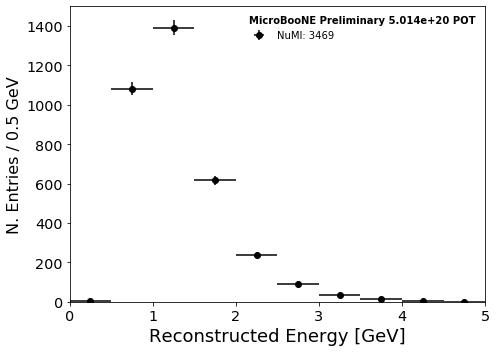

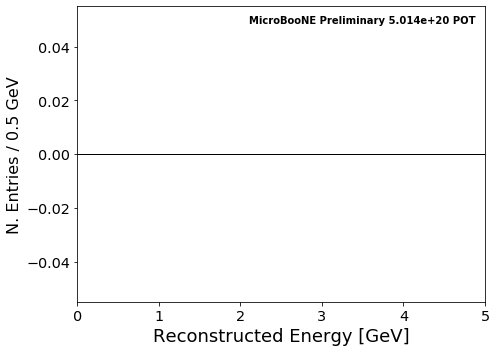

In [18]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_data.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_data.iloc[start:end]

    samples = {
        "numu_data": sample_set 
    }

    if isRun3 == False:
        pot =  2e+20 
    elif isRun3 == True:
        pot =  5.014e+20 
        
    weights = {  
                }
    
    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',5,(0, 5),"Number of Protons"
    #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',5,(0, 5),"Number of Contained Showers"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        #query= "",
        currentsample = "numu_data",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


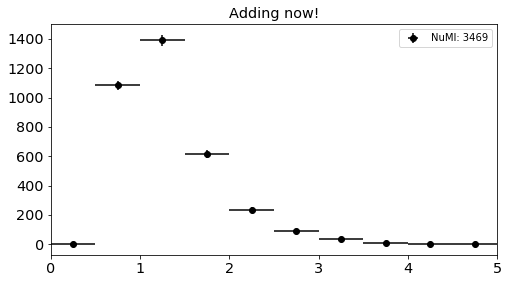

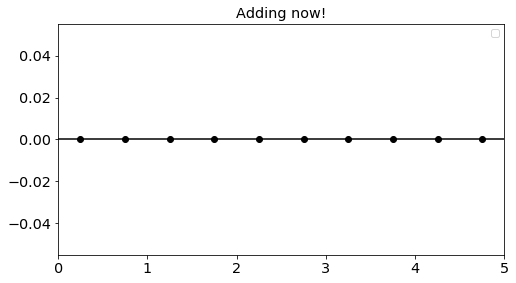

In [19]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom, muons
    current_bincenters =  np.arange(0.25, 5.25, 0.5)
    current_bin_size = 0.5
    #current_bincenters =  np.arange(0.5, 5.5, 1)
    #current_bin_size = 1
    ########################
    #numu_ax1.set_xlim([-20, 280])    #X
    #current_bincenters =  np.arange(-17.5, 282.5, 5)
    #current_bin_size = 5
    ########################
    #numu_ax1.set_xlim([-140, 140])    #Y
    #current_bincenters =  np.arange(-137.5, 142.5, 5)
    #current_bin_size = 5
    ########################
    #numu_ax1.set_xlim([-10, 1100])    #Z
    #current_bincenters =  np.arange(0, 1110, 20)
    #current_bin_size = 20
    ########################
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff
    #current_bincenters =  np.arange(-0.9, 1.1, 0.2)
    #current_bin_size = 0.25
    
    numu_ax1.errorbar(
                current_bincenters,
                varss[i],
                xerr=current_bin_size/2,
                yerr=weightss[i],
                fmt='ko',
                label="NuMI: %i" % sum(varss[i]) if sum(varss[i]) else "")
    
    plt.title("Adding now!")
    plt.legend()

In [20]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = sum(varss)
print(weightss[0][0])
#sum errors? will need to change if splitting data
weightss_tot = weightss[0][0]

[ 2.         32.89376841 37.2961124  24.81934729 15.39480432  9.48683298
  5.83095189  3.46410162  1.73205081  0.        ]


[   4 1082 1391  616  237   90   34   12    3    0]


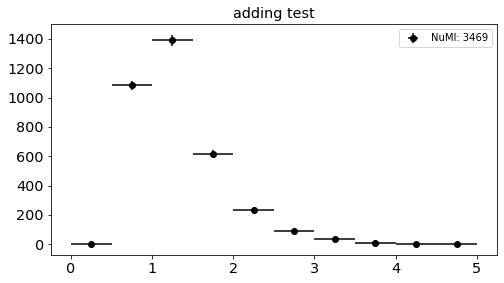

In [21]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = labss

numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_ylim([0, 4000])

#AngleDiff
#numu_ax1.set_xlim([-1,1])
#numu_ax1.set_ylim([0, 900])

print(varss_tot)

numu_ax1.errorbar(
            current_bincenters,
            varss_tot,
            xerr=current_bin_size/2,
            yerr=weightss_tot,
            fmt='ko',
            label="NuMI: %i" % sum(varss_tot) if sum(varss_tot) else "")


plt.title("adding test")
plt.legend()

In [22]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

if isRun3 == False:
    #######full trueE
    vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    #weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_angleDiff_usingSelection.csv')
    ########leptonMom
    #vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_leptonMom_usingSelection.csv')
    #weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_leptonMom_usingSelection.csv')
elif isRun3 == True:
    #######full trueE
    vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    #vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    #weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3.csv')
    ########leptonMom
    #vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
    #weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3.csv')
